In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import numpy as np
import h5py
from tqdm.auto import tqdm, trange
import scipy.io
import time
import torch
import random
import math
import shutil
from sklearn.decomposition import PCA
import scipy as sp
import scipy.signal
import os
import pandas as pd
from torch import nn

from analysis.proj import learn_manifold_umap, pca_train, pca
from analysis.plotting import plot_gmm
from analysis.contrastive_utils import load_GPT_backbone
from analysis.cluster import GMM, HDBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_rand_score
from analysis.cluster import MeanShift
from analysis.benchmarking import class_scores, avg_score, per_class_accs, avg_class_accs

from spike_psvae.denoise import SingleChanDenoiser

In [3]:
print(torch.version.cuda)

11.2


In [4]:
import matplotlib.pyplot as plt
# %matplotlib inline
plt.rc("figure", dpi=100)
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12
plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=MEDIUM_SIZE)
plt.rc('axes', labelsize=SMALL_SIZE)
plt.rc('xtick', labelsize=SMALL_SIZE)
plt.rc('ytick', labelsize=SMALL_SIZE)
plt.rc('legend', fontsize=SMALL_SIZE)
plt.rc('figure', titlesize=BIGGER_SIZE)

## Load Data

In [5]:
import MEArec as mr
data_base_dir = Path('/moto/stats/users/ch3676/datasets_contrastive_ephys/')
data_type = Path('multi_channel/DY016_random_neurons')
data_name = Path('dy016_random_neurons_04_28_2023')
data_path = data_base_dir / data_type / data_name

In [6]:
unit_ids = np.load(data_path / 'unit_ids.npy')
spikes_train = np.load(data_path / 'multichan_spikes_train.npy')
spikes_test = np.load(data_path / 'multichan_spikes_test.npy')
labels_test = np.load(data_path / 'labels_test.npy')
labels_train = np.load(data_path / 'labels_train.npy')
selected_units = np.load(data_path / 'selected_units.npy')

## Set PCA params

In [7]:
if len(spikes_train.shape) == 2:
    print("single channel waveforms")
    num_chan_pca = 1
    is_multi_chan = False
else:
    print("multi-channel waveforms")
    is_multi_chan = True

multi-channel waveforms


## Denoise

In [8]:
denoised_wfs_train = []
denoised_wfs_test = []

wfs_train = spikes_train.copy()
wfs_test = spikes_test.copy()

denoiser = SingleChanDenoiser()
denoiser.load('/moto/home/ch3676/spike-psvae/pretrained/single_chan_denoiser.pt')

for i in range(len(wfs_train)):
    curr_wf = wfs_train[i]
    with torch.no_grad():
        if not is_multi_chan:
            curr_wf = torch.unsqueeze(torch.from_numpy(curr_wf), dim=0)
            den_wf = denoiser(curr_wf)
        else:
            den_wf_ch_list = []
            for wf_ch in curr_wf:
                wf_ch = torch.unsqueeze(torch.from_numpy(wf_ch), dim=0)
                den_wf_ch = denoiser(wf_ch)
                den_wf_ch_list.append(den_wf_ch)
            den_wf = torch.concatenate(den_wf_ch_list)
        denoised_wfs_train.append(den_wf.squeeze().numpy())

denoised_wfs_train = np.array(denoised_wfs_train)
    
for i in range(len(wfs_test)):
    curr_wf = wfs_test[i]
    with torch.no_grad():
        if not is_multi_chan:
            curr_wf = torch.unsqueeze(torch.from_numpy(curr_wf), dim=0)
            den_wf = denoiser(curr_wf)
        else:
            den_wf_ch_list = []
            for wf_ch in curr_wf:
                wf_ch = torch.unsqueeze(torch.from_numpy(wf_ch), dim=0)
                den_wf_ch = denoiser(wf_ch)
                den_wf_ch_list.append(den_wf_ch)
            den_wf = torch.concatenate(den_wf_ch_list)
        denoised_wfs_test.append(den_wf.squeeze().numpy())
        
denoised_wfs_test = np.array(denoised_wfs_test)

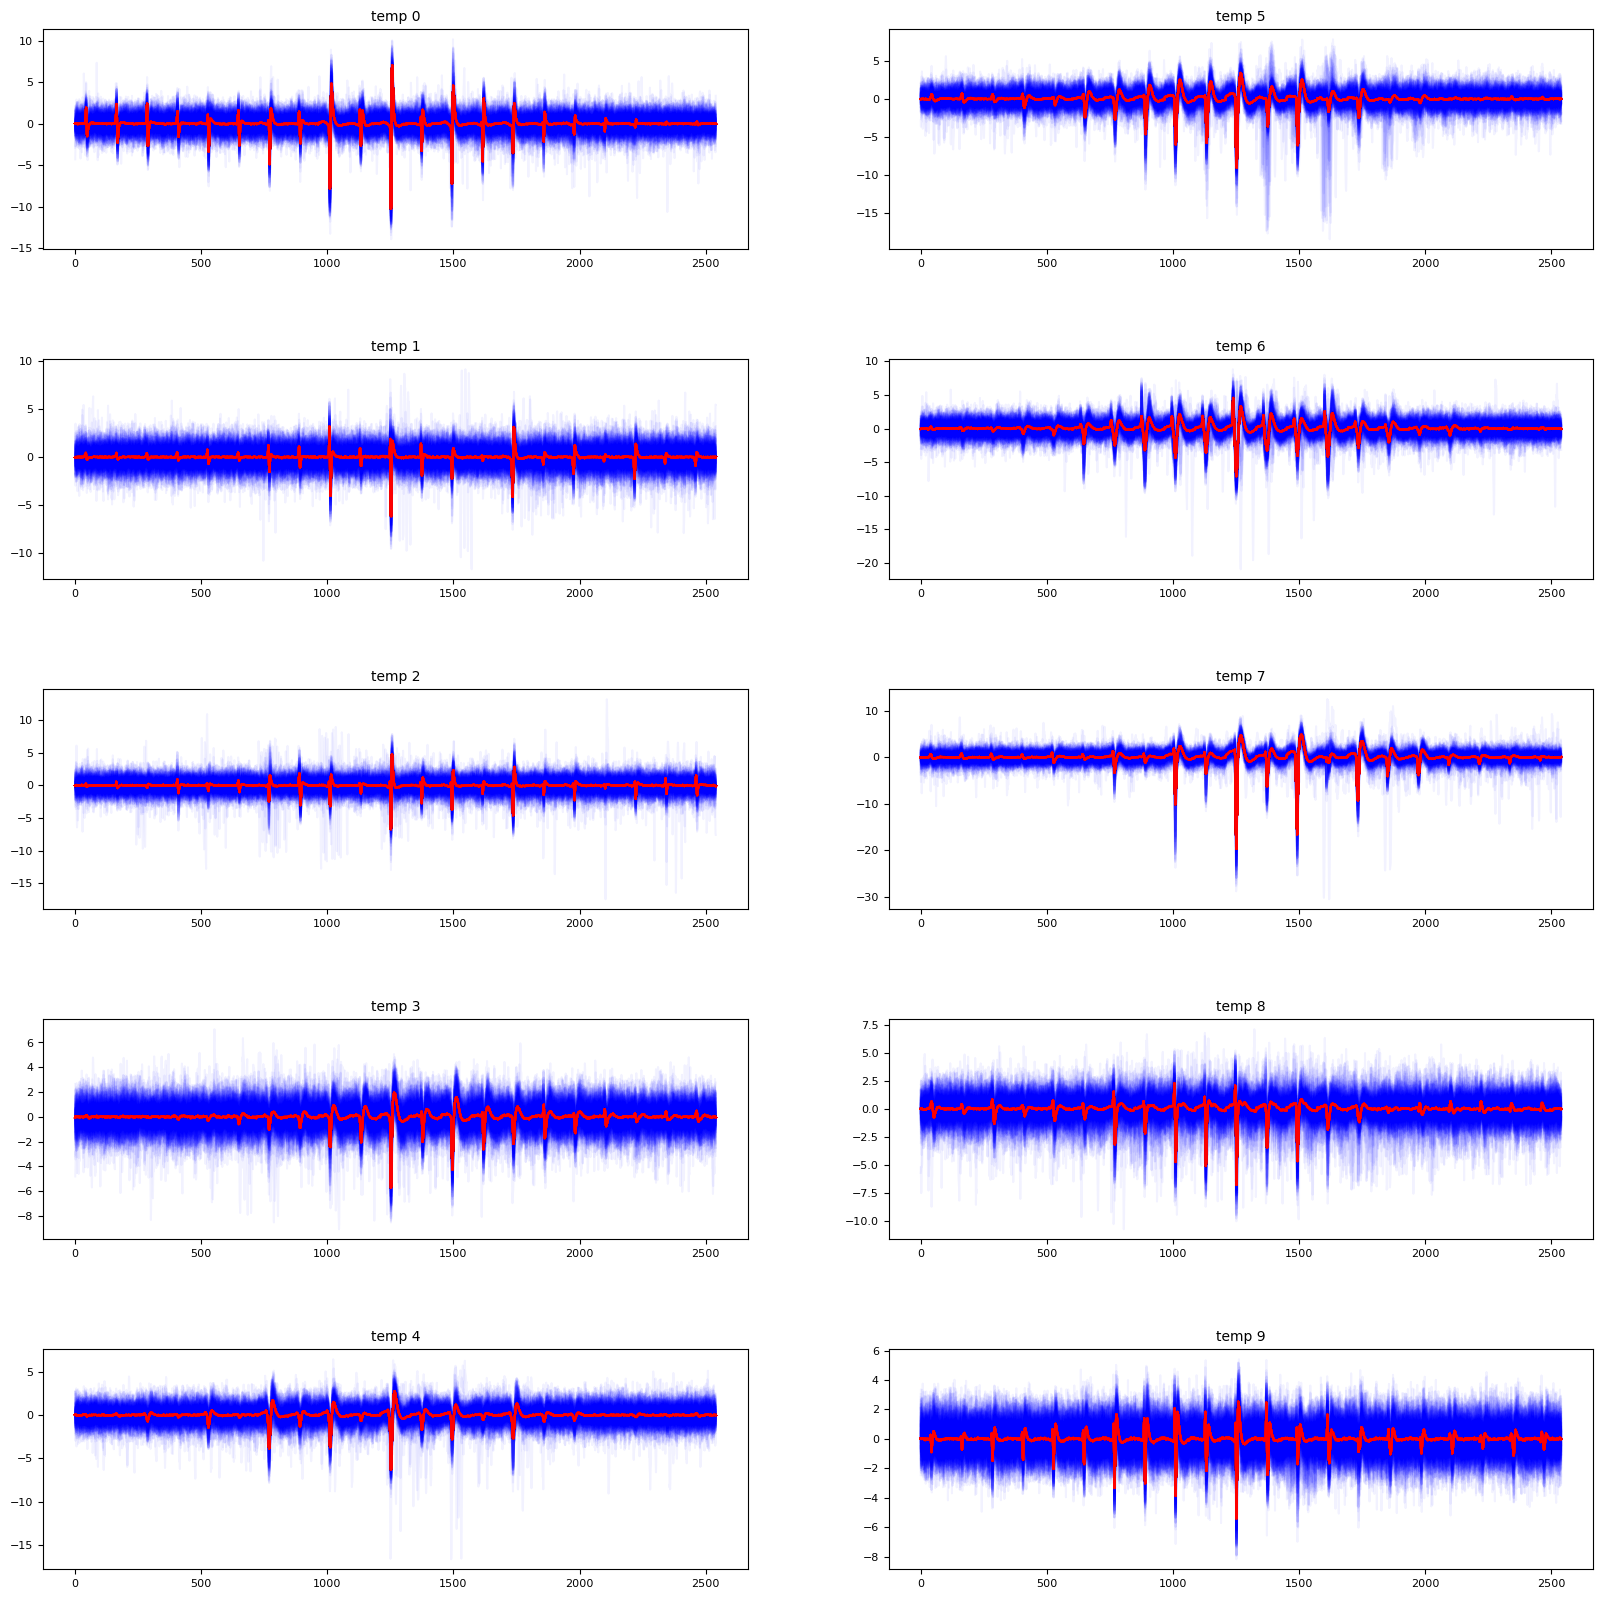

In [9]:
num_plot = 100
fig, axes = plt.subplots(5,2,figsize=(20,20))
for label_plot in range(len(np.unique(labels_train))):
    ax = axes[label_plot % 5][label_plot // 5]
    spikes = wfs_train[np.where(labels_train==label_plot)]
    for spike in spikes[:num_plot]:
        ax.plot(spike.flatten(), color='blue', alpha=.05)
        ax.plot(np.mean(spikes, 0).flatten(), color='red')
    ax.set_title(f'temp {label_plot}')
fig.subplots_adjust(hspace=0.5)
plt.show()

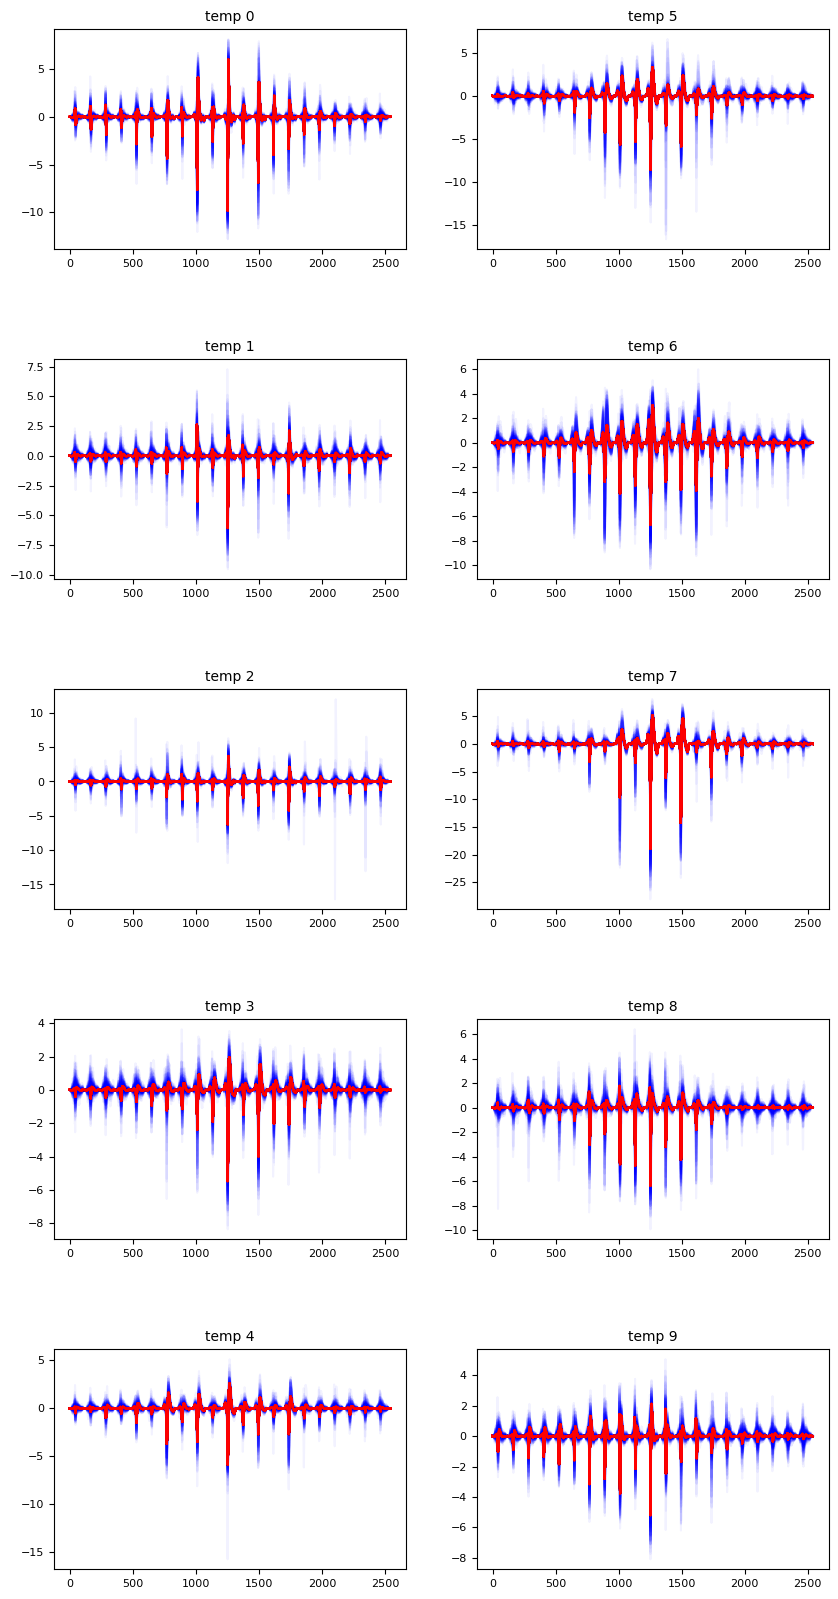

In [10]:
num_plot = 100
fig, axes = plt.subplots(5,2,figsize=(10,20))
for label_plot in range(len(np.unique(labels_train))):
    ax = axes[label_plot % 5][label_plot // 5]
    spikes = denoised_wfs_train[np.where(labels_train==label_plot)]
    for spike in spikes[:num_plot]:
        ax.plot(spike.flatten(), color='blue', alpha=.05)
        ax.plot(np.mean(spikes, 0).flatten(), color='red')
    ax.set_title(f'temp {label_plot}')
fig.subplots_adjust(hspace=0.5)
plt.show()

In [11]:
wfs_train_mean = np.mean(np.array([wf.flatten() for wf in wfs_train]), axis=0)
wfs_train_norm = np.array([wf.flatten() for wf in wfs_train]) - wfs_train_mean
wfs_test_norm = np.array([wf.flatten() for wf in wfs_test]) - wfs_train_mean

denoised_wfs_train_mean = np.mean(np.array([wf.flatten() for wf in denoised_wfs_train]), axis=0)
denoised_wfs_train_norm = np.array([wf.flatten() for wf in denoised_wfs_train]) - denoised_wfs_train_mean
denoised_wfs_test_norm = np.array([wf.flatten() for wf in denoised_wfs_test]) - denoised_wfs_train_mean


n_comps = 10
std_scale = 1
pcs_train, _, _ = pca(wfs_train_norm, n_comps) * std_scale
pcs_test, pcs_ex_var  = pca_train(wfs_train_norm, wfs_test_norm, n_comps) * std_scale
denoised_pcs_train, _, _  = pca(denoised_wfs_train_norm, n_comps) * std_scale
denoised_pcs_test, denoised_pcs_ex_var = pca_train(denoised_wfs_train_norm, denoised_wfs_test_norm, n_comps) * std_scale

train done
pca test done
train done
pca test done


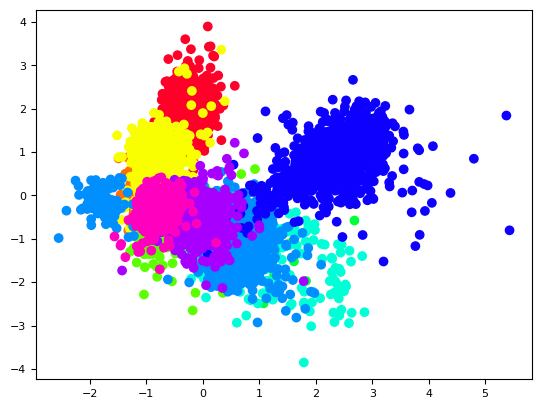

In [12]:
plt.scatter(denoised_pcs_train[:,0], denoised_pcs_train[:,1], c=labels_train, cmap='gist_rainbow');

In [13]:
plt.scatter(pcs_train[:,0], pcs_train[:,1], c=labels_train, cmap='gist_rainbow');

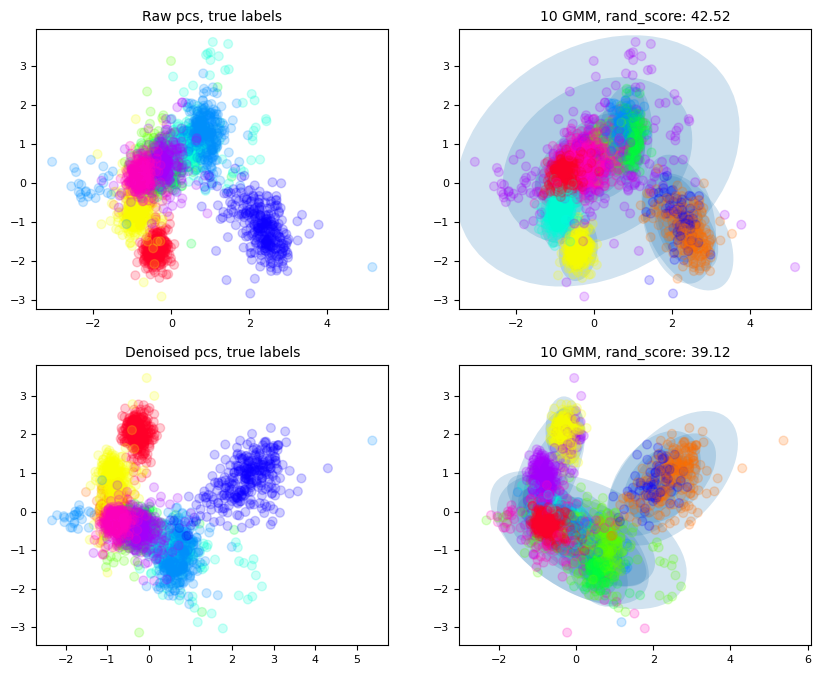

In [14]:
reps_train = pcs_train
reps_test = pcs_test

num_components = 5
covariance_type = 'full'
n_clusters = 10
pc_gmm = GaussianMixture(n_clusters, 
                         random_state=0, 
                         covariance_type=covariance_type).fit(reps_train[:,:num_components])
pc_test_labels = pc_gmm.predict(reps_test[:,:num_components])


reps_train = denoised_pcs_train
reps_test = denoised_pcs_test

num_components = 5
covariance_type = 'full'
n_clusters = 10
denoised_pc_gmm = GaussianMixture(n_clusters, 
                                  random_state=0, 
                                  covariance_type=covariance_type).fit(reps_train[:,:num_components])
denoised_pc_test_labels = denoised_pc_gmm.predict(reps_test[:,:num_components])

fig, axes = plt.subplots(2,2,figsize=(10,8))
X = pcs_test[:,:num_components]
score = adjusted_rand_score(labels_test, pc_test_labels)*100
row = 0
gmm = pc_gmm
axes[row][0].scatter(X[:, 0], X[:, 1], c=labels_test, s=40, cmap='gist_rainbow', zorder=2, alpha=.2)
plot_gmm(gmm, X, label=True, ax=axes[row][1])
axes[row][0].set_title('Raw pcs, true labels')
axes[row][1].set_title(f'10 GMM, rand_score: {np.round(score,2)}');

X = denoised_pcs_test[:,:num_components]
score = adjusted_rand_score(labels_test, denoised_pc_test_labels)*100
row = 1
gmm = denoised_pc_gmm
axes[row][0].scatter(X[:, 0], X[:, 1], c=labels_test, s=40, cmap='gist_rainbow', zorder=2, alpha=.2)
plot_gmm(gmm, X, label=True, ax=axes[row][1])
axes[row][0].set_title('Denoised pcs, true labels')
axes[row][1].set_title(f'10 GMM, rand_score: {np.round(score,2)}');

In [15]:
from models.model_GPT import Multi_GPT, Single_GPT, GPTConfig
#change params based on checkpoint
GPTConfig.out_dim = 5
GPTConfig.proj_dim = 5 

#common changes for single + multichan
GPTConfig.bias = False
GPTConfig.n_layer = 20
GPTConfig.is_causal = True

if not is_multi_chan:
    GPTConfig.pos = 'seq_11times'
else:
    GPTConfig.pos = 'conseq'
if not is_multi_chan:
    GPTConfig.n_embd = 32
else:
    GPTConfig.n_embd = 64
GPTConfig.n_head = 4
if not is_multi_chan:
    GPTConfig.block_size = 121
else:
    GPTConfig.block_size = 1331
if not is_multi_chan:
    GPTConfig.multi_chan = False
else:
    GPTConfig.multi_chan = True
    
#use reps or projections
use_reps = False

#choose model class
if not is_multi_chan:
    model = Single_GPT(GPTConfig)
else:
    model = Multi_GPT(GPTConfig)

#load checkpoint
path_to_checkpoint = Path('/moto/stats/users/ch3676/spike_ddp_models_0504/0502_mc_gpt_conseq_causal_nembd64_block1331_bs128_extra5_lr0.0001_knn10_addtrain')
checkpoint_path = path_to_checkpoint / 'checkpoint.pth'
checkpoint = torch.load(checkpoint_path, map_location="cpu")

#load GPT backbone only
model = load_GPT_backbone(model, checkpoint, is_multi_chan)
# if use_reps:
#     model.projector = nn.Identity()
#     model.online_head = nn.Identity()
model.eval() ; 

number of parameters: 0.99M


In [16]:
num_extra_chans = int(GPTConfig.block_size / 121 // 2)
batch_size = 128

wfs_train_crop = wfs_train[:,wfs_train.shape[1]//2 - num_extra_chans: wfs_train.shape[1]//2 + num_extra_chans + 1]
num_plot = 100
fig, axes = plt.subplots(5,2,figsize=(10,20))
for label_plot in range(len(np.unique(labels_train))):
    ax = axes[label_plot % 5][label_plot // 5]
    spikes = wfs_train_crop[np.where(labels_train==label_plot)]
    for spike in spikes[:num_plot]:
        ax.plot(spike.flatten(), color='blue', alpha=.05)
        ax.plot(np.mean(spikes, 0).flatten(), color='red')
    ax.set_title(f'temp {label_plot}')
fig.subplots_adjust(hspace=0.5)
plt.show()

In [49]:
from data_aug.contrastive_learning_dataset import ContrastiveLearningDataset, WFDataset_lab
from data_aug import Crop

num_extra_chans = int(GPTConfig.block_size / 121 // 2)
batch_size = 128
data_path = '/moto/stats/users/ch3676/datasets_contrastive_ephys/multi_channel/DY016_random_neurons/dy016_random_neurons_04_28_2023/'

test_dataset = WFDataset_lab(data_path, split='test', multi_chan=is_multi_chan, 
                             transform=Crop(prob=0.0, num_extra_chans=num_extra_chans, ignore_chan_num=True))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, 
                                          shuffle=False, num_workers=10, 
                                          pin_memory=True, drop_last=False)

(3000, 21, 121)


In [64]:
cont_reps_test = []
with torch.no_grad():
    for data, target in test_loader:
        if not is_multi_chan:
            data = torch.squeeze(data, dim=1)
            data = torch.unsqueeze(data, dim=-1)
        else:
            data = data.view(-1, 11*121)
            data = torch.unsqueeze(data, dim=-1)

        feature = model(data)
        cont_reps_test.append(feature)

    # feature_bank = torch.cat(feature_bank, dim=0)
    # print(feature_bank.shape)

/moto/stats/users/ch3676/micromamba/envs/spike/lib/python3.10/site-packages/torch/cuda/__init__.py:107: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9000). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at /home/conda/feedstock_root/build_artifacts/pytorch-recipe_1680572619157/work/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [68]:
cont_reps_test[0][0]

tensor([-0.7561, -0.5856, -0.6390,  0.9150, -0.9181])

In [71]:
cont_reps_test2[0]

array([-1.4063147 , -0.18351592,  0.6616857 ,  1.3192434 , -0.3080549 ],
      dtype=float32)

In [50]:
# data_path = '/moto/stats/users/ch3676/spike_ddp_models_0504/0502_mc_gpt_conseq_causal_nembd64_block1331_bs128_extra5_lr0.0001_knn10_addtrain'

In [43]:
# num_extra_chans = int(GPTConfig.block_size / 121 // 2)
# batch_size = 128

# wfs_train_torch = torch.from_numpy(wfs_train[:,wfs_train.shape[1]//2 - num_extra_chans: wfs_train.shape[1]//2 + num_extra_chans + 1,:,None])
# cont_reps_train = []
# for i in tqdm(range(0, len(wfs_train_torch), batch_size), desc='Processing train batches'):
#     batch = wfs_train_torch[i:i+batch_size]
#     wfs_train_cont = model.forward(batch.flatten(1,2))
#     wfs_train_cont_numpy = wfs_train_cont.detach().numpy()
#     cont_reps_train.append(wfs_train_cont_numpy)
#     del wfs_train_cont

wfs_test_torch = torch.from_numpy(wfs_test[:,wfs_test.shape[1]//2 - num_extra_chans: wfs_test.shape[1]//2 + num_extra_chans + 1,:,None])
cont_reps_test = []
for i in tqdm(range(0, len(wfs_test_torch), batch_size), desc='Processing test batches'):
    batch = wfs_test_torch[i:i+batch_size]
    batch = batch.view(-1, 11*121)
    batch = torch.unsqueeze(batch, dim=-1)
    wfs_test_cont = model.forward(batch)
    wfs_test_cont_numpy = wfs_test_cont.detach().numpy()
    cont_reps_test.append(wfs_test_cont_numpy)
    del wfs_test_cont
    
# cont_reps_train = np.concatenate(cont_reps_train)
cont_reps_test = np.concatenate(cont_reps_test)

Processing test batches:   0%|          | 0/24 [00:00<?, ?it/s]

In [44]:
cont_reps_test

array([[-0.7561004 , -0.58560854, -0.63899314,  0.9149711 , -0.9181259 ],
       [-0.37860507, -0.25237715, -0.4873447 ,  0.09885422, -0.6288064 ],
       [-1.1708218 , -0.7276683 , -1.3095449 ,  0.19694422, -0.6116948 ],
       ...,
       [-0.4039152 , -0.18880484, -0.80689526, -0.45445216, -0.39580154],
       [-0.39986023, -0.06693995, -0.9566451 , -0.08911819, -0.6540816 ],
       [-0.55575085, -0.3847882 , -1.1122438 , -0.37690806, -0.8039019 ]],
      dtype=float32)

In [23]:
# load representations
path_to_reps = Path('/moto/stats/users/ch3676/spike_ddp_models_0504/0502_mc_gpt_conseq_causal_nembd64_block1331_bs128_extra5_lr0.0001_knn10_addtrain')
cont_reps_train2 = torch.load(path_to_reps / 'train_reps.pt', map_location='cpu').numpy()
cont_reps_test2 = torch.load(path_to_reps / 'test_reps.pt', map_location='cpu').numpy()

In [45]:
cont_reps_test2

array([[-1.4063147 , -0.18351592,  0.6616857 ,  1.3192434 , -0.3080549 ],
       [-1.3467429 , -0.33851132,  0.58625686,  1.1967214 ,  0.1974089 ],
       [-1.8273019 , -0.24363652,  0.6615122 ,  1.065934  , -0.2545026 ],
       ...,
       [-0.1065241 , -0.91520727,  0.63327485, -0.17979181, -0.47797394],
       [ 0.3433826 , -1.1868529 ,  0.28988728,  0.36461657, -0.23747174],
       [-0.08988042, -1.3297894 ,  0.69966173,  0.05411196, -0.1680895 ]],
      dtype=float32)

In [20]:
from sklearn.mixture import GaussianMixture
import hdbscan
import numpy as np
from sklearn.metrics import adjusted_rand_score

# covariance_type : {'full', 'tied', 'diag', 'spherical'}
# reps_train = pcs_train
# reps_test = pcs_test
covariance_type = 'full'
n_clusters = 10
reps_train = cont_reps_train
reps_test = cont_reps_test
gmm_list_cont = []
num_components = np.arange(5, reps_train.shape[1]+1)
for num_c in num_components:
    gmm = GaussianMixture(n_clusters, 
                          random_state=0, 
                          covariance_type=covariance_type).fit(reps_train[:,:num_c])
    gmm_list_cont.append(gmm)
    gmm_cont_test_labels = gmm.predict(reps_test[:,:num_c])
    score = adjusted_rand_score(labels_test, gmm_cont_test_labels)*100
    print(f"num_comps: {num_c}, rand_score: {score}")

num_comps: 5, rand_score: 14.455585495725643


In [21]:
pcs_train_cont, _, _ = pca(cont_reps_train, n_comps=2)
pcs_test_cont, pcs_ex_var  = pca_train(cont_reps_train, cont_reps_test, n_comps=2)

train done
pca test done


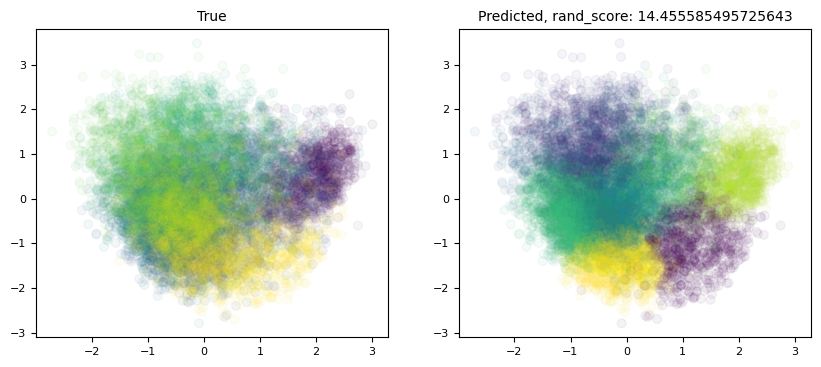

In [22]:
fig, axes = plt.subplots(1,2,figsize=(10,4))
X = pcs_train_cont
gmm = gmm_list_cont[0]
train_labels = gmm.predict(cont_reps_train)
axes[0].scatter(X[:, 0], X[:, 1], c=labels_train, s=40, cmap='viridis', zorder=2, alpha=.05)
axes[1].scatter(X[:, 0], X[:, 1], c=train_labels, s=40, cmap='viridis', zorder=2, alpha=.05)
# plot_gmm(gmm, wfs_train_cont_numpy, label=True, ax=axes[1])
gmm_cont_test_labels = gmm.predict(cont_reps_test)
score = adjusted_rand_score(labels_test, gmm_cont_test_labels)*100
axes[0].set_title('True')
axes[1].set_title(f'Predicted, rand_score: {score}');

In [27]:
cont_test_umap = learn_manifold_umap(cont_reps_test, umap_dim=2, umap_min_dist=0.2, umap_metric='euclidean', umap_neighbors=10)
clustering = MeanShift(bandwidth=2, n_jobs=20).fit(cont_test_umap)
labels_test_ms = clustering.predict(cont_test_umap)
score = adjusted_rand_score(labels_test, labels_test_ms)*100
print(score)

number of seeds: 3000
seeds/job: 151
using 20 cpus


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   3 out of  20 | elapsed:  2.4min remaining: 13.8min
[Parallel(n_jobs=20)]: Done  14 out of  20 | elapsed:  2.5min remaining:  1.1min


predicting
90.68259878861758


[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:  2.5min finished


Text(0, 0.5, 'raw pc2')

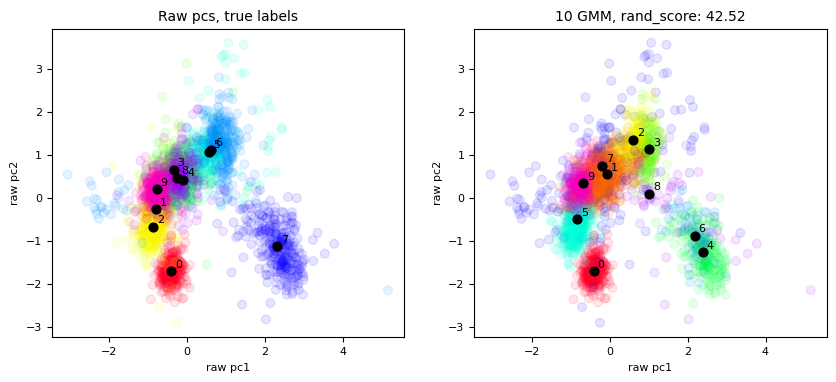

In [34]:
X = pcs_test
labels_pred = pc_test_labels
annotate_offset = .1
fig, axes = plt.subplots(1,2,figsize=(10,4))
axes[0].scatter(X[:, 0], X[:, 1], c=labels_test, s=40, cmap='gist_rainbow', zorder=2, alpha=.1)
for label_plot in range(len(np.unique(labels_test))):
    mean_location = np.mean(X[np.where(labels_test==label_plot)],0)
    axes[0].scatter(mean_location[0], mean_location[1],color='black', alpha=1, s=40, zorder=2)
    axes[0].annotate(f'{label_plot}', (mean_location[0]+annotate_offset, mean_location[1]+annotate_offset))
axes[0].set_title('Raw pcs, true labels')
axes[0].set_xlabel('raw pc1')
axes[0].set_ylabel('raw pc2')
axes[1].scatter(X[:, 0], X[:, 1], c=labels_pred, s=40, cmap='gist_rainbow', zorder=2, alpha=.1)
for label_plot in range(len(np.unique(labels_pred))):
    mean_location = np.mean(X[np.where(labels_pred==label_plot)],0)
    axes[1].scatter(mean_location[0], mean_location[1],color='black', alpha=1, s=40, zorder=2)
    axes[1].annotate(f'{label_plot}', (mean_location[0]+annotate_offset, mean_location[1]+annotate_offset))
score = adjusted_rand_score(labels_test, labels_pred)*100
axes[1].set_title(f'10 GMM, rand_score: {np.round(score,decimals=2)}');
axes[1].set_xlabel('raw pc1')
axes[1].set_ylabel('raw pc2')

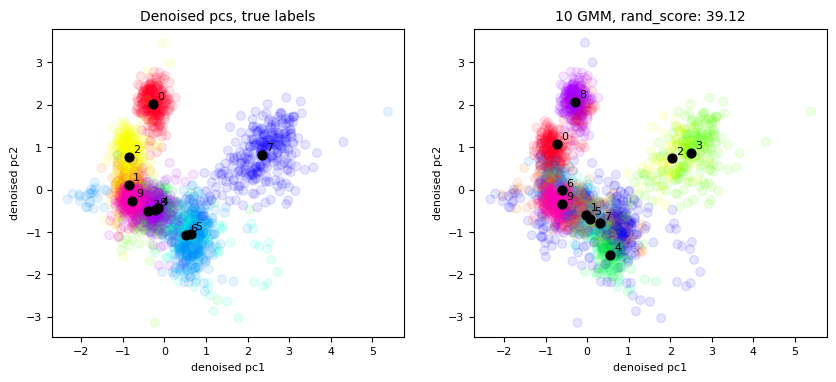

In [35]:
X = denoised_pcs_test
labels_pred = denoised_pc_test_labels
annotate_offset = .1
fig, axes = plt.subplots(1,2,figsize=(10,4))
axes[0].scatter(X[:, 0], X[:, 1], c=labels_test, s=40, cmap='gist_rainbow', zorder=2, alpha=.1)
for label_plot in range(len(np.unique(labels_test))):
    mean_location = np.mean(X[np.where(labels_test==label_plot)],0)
    axes[0].scatter(mean_location[0], mean_location[1],color='black', alpha=1, s=40, zorder=2)
    axes[0].annotate(f'{label_plot}', (mean_location[0]+annotate_offset, mean_location[1]+annotate_offset))
axes[0].set_title('Denoised pcs, true labels')
axes[0].set_xlabel('denoised pc1')
axes[0].set_ylabel('denoised pc2')
axes[1].scatter(X[:, 0], X[:, 1], c=labels_pred, s=40, cmap='gist_rainbow', zorder=2, alpha=.1)
for label_plot in range(len(np.unique(labels_pred))):
    mean_location = np.mean(X[np.where(labels_pred==label_plot)],0)
    axes[1].scatter(mean_location[0], mean_location[1],color='black', alpha=1, s=40, zorder=2)
    axes[1].annotate(f'{label_plot}', (mean_location[0]+annotate_offset, mean_location[1]+annotate_offset))
score = adjusted_rand_score(labels_test, labels_pred)*100
axes[1].set_title(f'10 GMM, rand_score: {np.round(score,decimals=2)}')
axes[1].set_xlabel('denoised pc1')
axes[1].set_ylabel('denoised pc2');

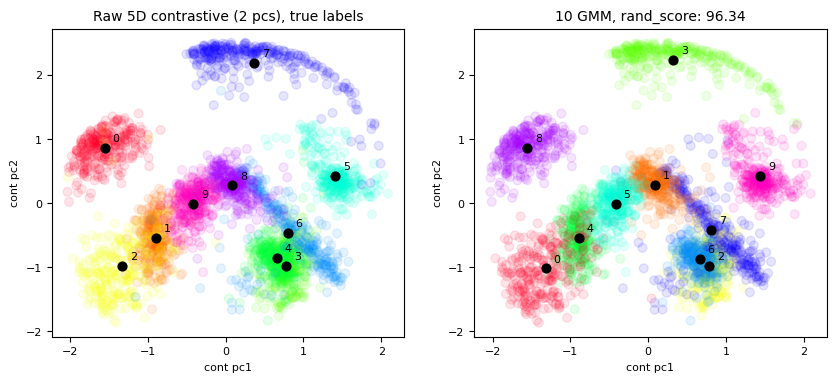

In [36]:
X = pcs_test_cont
labels_pred = gmm_cont_test_labels
annotate_offset = .1
fig, axes = plt.subplots(1,2,figsize=(10,4))
axes[0].scatter(X[:, 0], X[:, 1], c=labels_test, s=40, cmap='gist_rainbow', zorder=2, alpha=.1)
for label_plot in range(len(np.unique(labels_test))):
    mean_location = np.mean(X[np.where(labels_test==label_plot)],0)
    axes[0].scatter(mean_location[0], mean_location[1],color='black', alpha=1, s=40, zorder=2)
    axes[0].annotate(f'{label_plot}', (mean_location[0]+annotate_offset, mean_location[1]+annotate_offset))
axes[0].set_title('Raw 5D contrastive (2 pcs), true labels')
axes[0].set_xlabel('cont pc1')
axes[0].set_ylabel('cont pc2');
axes[1].scatter(X[:, 0], X[:, 1], c=labels_pred, s=40, cmap='gist_rainbow', zorder=2, alpha=.1)
for label_plot in range(len(np.unique(labels_pred))):
    mean_location = np.mean(X[np.where(labels_pred==label_plot)],0)
    axes[1].scatter(mean_location[0], mean_location[1],color='black', alpha=1, s=40, zorder=2)
    axes[1].annotate(f'{label_plot}', (mean_location[0]+annotate_offset, mean_location[1]+annotate_offset))
score = adjusted_rand_score(labels_test, labels_pred)*100
axes[1].set_title(f'10 GMM, rand_score: {np.round(score,decimals=2)}');
axes[1].set_xlabel('cont pc1')
axes[1].set_ylabel('cont pc2');

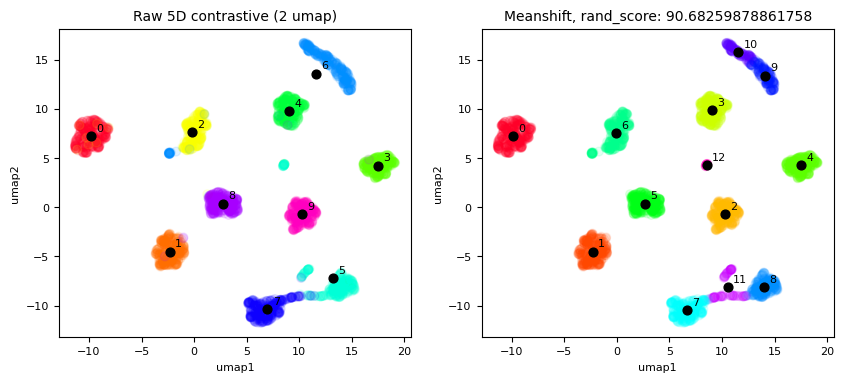

In [37]:
X = cont_test_umap
labels_pred = labels_test_ms
annotate_offset = .5
fig, axes = plt.subplots(1,2,figsize=(10,4))
axes[0].scatter(X[:, 0], X[:, 1], c=labels_test, s=40, cmap='gist_rainbow', zorder=2, alpha=.1)
for label_plot in range(len(np.unique(labels_test))):
    mean_location = np.mean(X[np.where(labels_test==label_plot)],0)
    axes[0].scatter(mean_location[0], mean_location[1],color='black', alpha=1, s=40, zorder=2)
    axes[0].annotate(f'{label_plot}', (mean_location[0]+annotate_offset, mean_location[1]+annotate_offset))
axes[0].set_title('Raw 5D contrastive (2 umap)')
axes[0].set_xlabel('umap1')
axes[0].set_ylabel('umap2');
axes[1].scatter(X[:, 0], X[:, 1], c=labels_pred, s=40, cmap='gist_rainbow', zorder=2, alpha=.1)
for label_plot in range(len(np.unique(labels_pred))):
    mean_location = np.mean(X[np.where(labels_pred==label_plot)],0)
    axes[1].scatter(mean_location[0], mean_location[1],color='black', alpha=1, s=40, zorder=2)
    axes[1].annotate(f'{label_plot}', (mean_location[0]+annotate_offset, mean_location[1]+annotate_offset))
score = adjusted_rand_score(labels_test, labels_pred)*100
axes[1].set_title(f'Meanshift, rand_score: {score}');
axes[1].set_xlabel('umap1')
axes[1].set_ylabel('umap2');

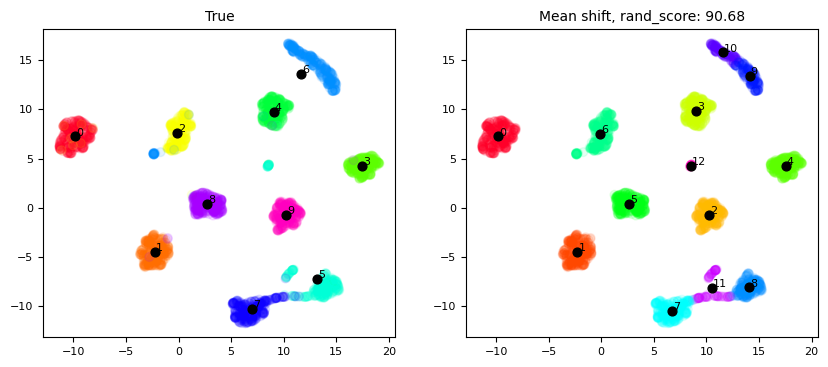

In [38]:
X = cont_test_umap
labels_pred = labels_test_ms
annotate_offset = .1
fig, axes = plt.subplots(1,2,figsize=(10,4))
axes[0].scatter(X[:, 0], X[:, 1], c=labels_test, s=40, cmap='gist_rainbow', zorder=2, alpha=.1)
for label_plot in range(len(np.unique(labels_test))):
    mean_location = np.mean(X[np.where(labels_test==label_plot)],0)
    axes[0].scatter(mean_location[0], mean_location[1],color='black', alpha=1, s=40, zorder=2)
    axes[0].annotate(f'{label_plot}', (mean_location[0]+annotate_offset, mean_location[1]+annotate_offset))
axes[0].set_title('True')
axes[1].scatter(X[:, 0], X[:, 1], c=labels_pred, s=40, cmap='gist_rainbow', zorder=2, alpha=.1)
for label_plot in range(len(np.unique(labels_pred))):
    mean_location = np.mean(X[np.where(labels_pred==label_plot)],0)
    axes[1].scatter(mean_location[0], mean_location[1],color='black', alpha=1, s=40, zorder=2)
    axes[1].annotate(f'{label_plot}', (mean_location[0]+annotate_offset, mean_location[1]+annotate_offset))
score = adjusted_rand_score(labels_test, labels_pred)*100
axes[1].set_title(f'Mean shift, rand_score: {np.round(score,decimals=2)}');

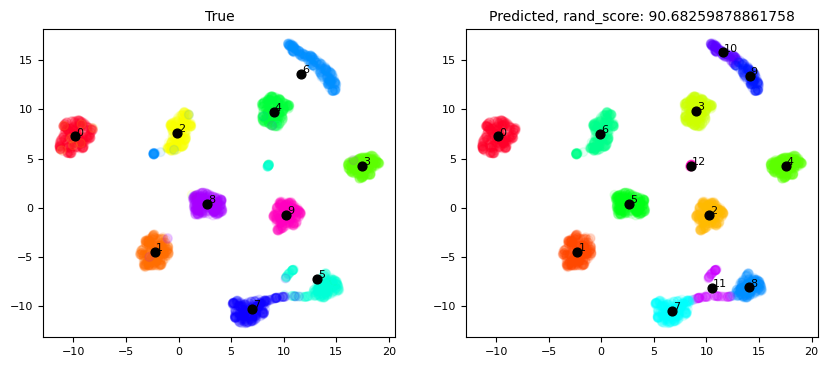

In [39]:
X = cont_test_umap
labels_pred = labels_test_ms
annotate_offset = .1
fig, axes = plt.subplots(1,2,figsize=(10,4))
axes[0].scatter(X[:, 0], X[:, 1], c=labels_test, s=40, cmap='gist_rainbow', zorder=2, alpha=.1)
for label_plot in range(len(np.unique(labels_test))):
    mean_location = np.mean(X[np.where(labels_test==label_plot)],0)
    axes[0].scatter(mean_location[0], mean_location[1],color='black', alpha=1, s=40, zorder=2)
    axes[0].annotate(f'{label_plot}', (mean_location[0]+annotate_offset, mean_location[1]+annotate_offset))
axes[0].set_title('True')
axes[1].scatter(X[:, 0], X[:, 1], c=labels_pred, s=40, cmap='gist_rainbow', zorder=2, alpha=.1)
for label_plot in range(len(np.unique(labels_pred))):
    mean_location = np.mean(X[np.where(labels_pred==label_plot)],0)
    axes[1].scatter(mean_location[0], mean_location[1],color='black', alpha=1, s=40, zorder=2)
    axes[1].annotate(f'{label_plot}', (mean_location[0]+annotate_offset, mean_location[1]+annotate_offset))
score = adjusted_rand_score(labels_test, labels_pred)*100
axes[1].set_title(f'Predicted, rand_score: {score}');

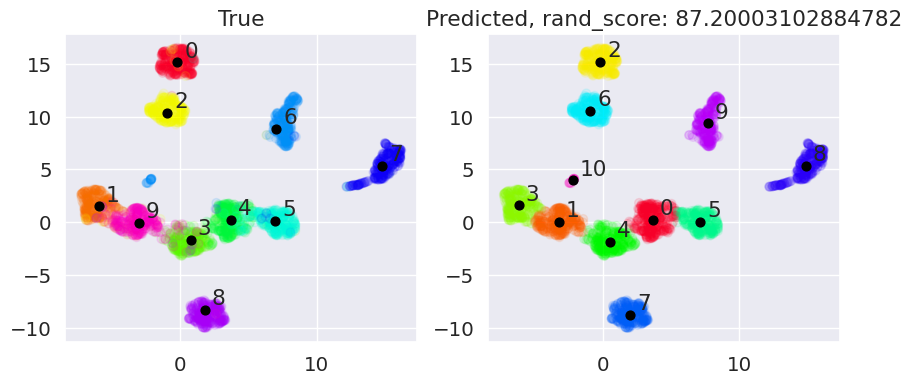

In [56]:
X = cont_test_umap
labels_pred = labels_test_ms
annotate_offset = .5
fig, axes = plt.subplots(1,2,figsize=(10,4))
axes[0].scatter(X[:, 0], X[:, 1], c=labels_test, s=40, cmap='gist_rainbow', zorder=2, alpha=.1)
for label_plot in range(len(np.unique(labels_test))):
    mean_location = np.mean(X[np.where(labels_test==label_plot)],0)
    axes[0].scatter(mean_location[0], mean_location[1],color='black', alpha=1, s=40, zorder=2)
    axes[0].annotate(f'{label_plot}', (mean_location[0]+annotate_offset, mean_location[1]+annotate_offset))
axes[0].set_title('True')
axes[1].scatter(X[:, 0], X[:, 1], c=labels_pred, s=40, cmap='gist_rainbow', zorder=2, alpha=.1)
for label_plot in range(len(np.unique(labels_pred))):
    mean_location = np.mean(X[np.where(labels_pred==label_plot)],0)
    axes[1].scatter(mean_location[0], mean_location[1],color='black', alpha=1, s=40, zorder=2)
    axes[1].annotate(f'{label_plot}', (mean_location[0]+annotate_offset, mean_location[1]+annotate_offset))
score = adjusted_rand_score(labels_test, labels_pred)*100
axes[1].set_title(f'Predicted, rand_score: {score}');

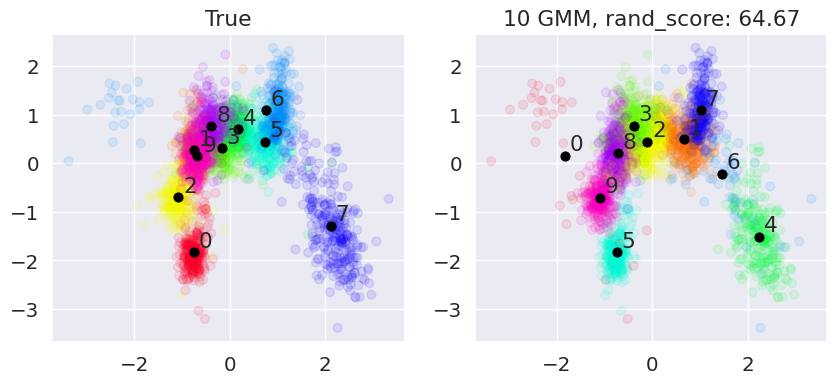

In [90]:
X = pcs_test
labels_pred = pc_test_labels
annotate_offset = .1
fig, axes = plt.subplots(1,2,figsize=(10,4))
axes[0].scatter(X[:, 0], X[:, 1], c=labels_test, s=40, cmap='gist_rainbow', zorder=2, alpha=.1)
for label_plot in range(len(np.unique(labels_test))):
    mean_location = np.mean(X[np.where(labels_test==label_plot)],0)
    axes[0].scatter(mean_location[0], mean_location[1],color='black', alpha=1, s=40, zorder=2)
    axes[0].annotate(f'{label_plot}', (mean_location[0]+annotate_offset, mean_location[1]+annotate_offset))
axes[0].set_title('True')
axes[1].scatter(X[:, 0], X[:, 1], c=labels_pred, s=40, cmap='gist_rainbow', zorder=2, alpha=.1)
for label_plot in range(len(np.unique(labels_pred))):
    mean_location = np.mean(X[np.where(labels_pred==label_plot)],0)
    axes[1].scatter(mean_location[0], mean_location[1],color='black', alpha=1, s=40, zorder=2)
    axes[1].annotate(f'{label_plot}', (mean_location[0]+annotate_offset, mean_location[1]+annotate_offset))
score = adjusted_rand_score(labels_test, labels_pred)*100
axes[1].set_title(f'10 GMM, rand_score: {np.round(score,decimals=2)}');

In [ ]:
X = pcs_test
labels_pred = pc_test_labels
annotate_offset = .1
fig, axes = plt.subplots(1,2,figsize=(10,4))
axes[0].scatter(X[:, 0], X[:, 1], c=labels_test, s=40, cmap='gist_rainbow', zorder=2, alpha=.1)
for label_plot in range(len(np.unique(labels_test))):
    mean_location = np.mean(X[np.where(labels_test==label_plot)],0)
    axes[0].scatter(mean_location[0], mean_location[1],color='black', alpha=1, s=40, zorder=2)
    axes[0].annotate(f'{label_plot}', (mean_location[0]+annotate_offset, mean_location[1]+annotate_offset))
axes[0].set_title('True')
axes[1].scatter(X[:, 0], X[:, 1], c=labels_pred, s=40, cmap='gist_rainbow', zorder=2, alpha=.1)
for label_plot in range(len(np.unique(labels_pred))):
    mean_location = np.mean(X[np.where(labels_pred==label_plot)],0)
    axes[1].scatter(mean_location[0], mean_location[1],color='black', alpha=1, s=40, zorder=2)
    axes[1].annotate(f'{label_plot}', (mean_location[0]+annotate_offset, mean_location[1]+annotate_offset))
score = adjusted_rand_score(labels_test, labels_pred)*100
axes[1].set_title(f'10 GMM, rand_score: {np.round(score,decimals=2)}');

In [ ]:
np.round

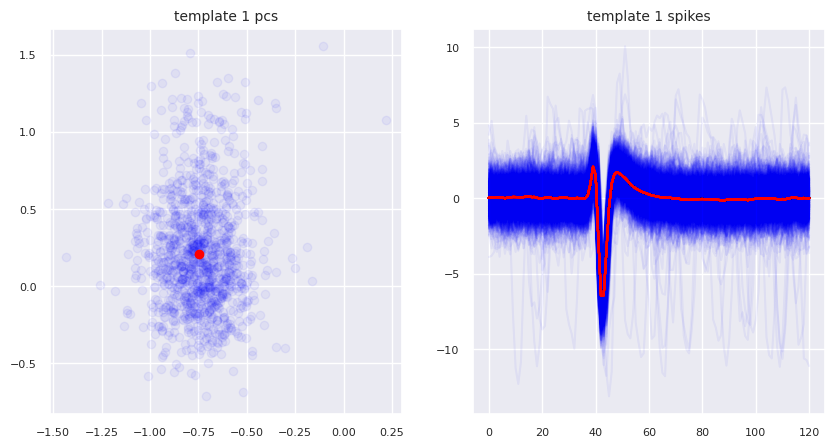

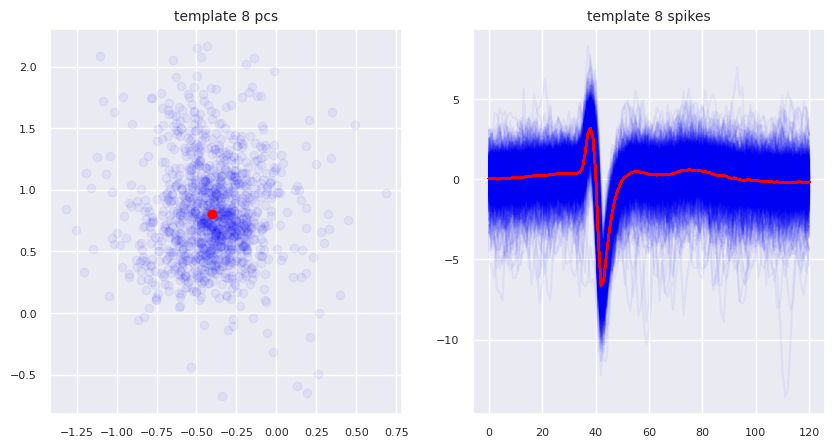

In [159]:
num_plot = 1200
units_plot = [1, 5, 6, 0, 8]
for label_plot in units_plot:#range(len(np.unique(labels_train))):
    fig, axes = plt.subplots(1,2,figsize=(10,5))
    pcs = pcs_train[np.where(labels_train==label_plot)][:num_plot]
    axes[0].scatter(pcs[:,0], pcs[:,1], color='blue', alpha=.05)
    axes[0].scatter(np.mean(pcs,0)[0], np.mean(pcs,0)[1], color='red', alpha=1)
    spikes = wfs_train[np.where(labels_train==label_plot)]
    for spike in spikes[:num_plot]:
        axes[1].plot(spike.flatten(), color='blue', alpha=.05)
        axes[1].plot(np.mean(spikes, 0).flatten(), color='red')
    axes[0].set_title(f'template {label_plot} pcs')
    axes[1].set_title(f'template {label_plot} spikes')
    plt.show()

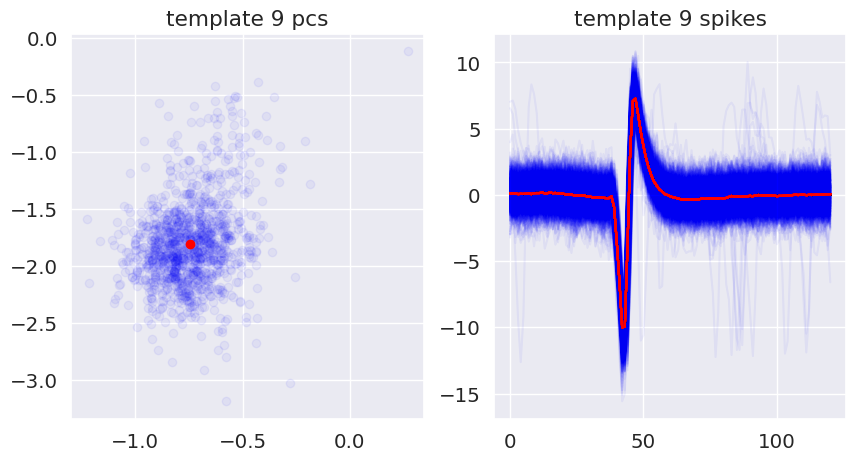

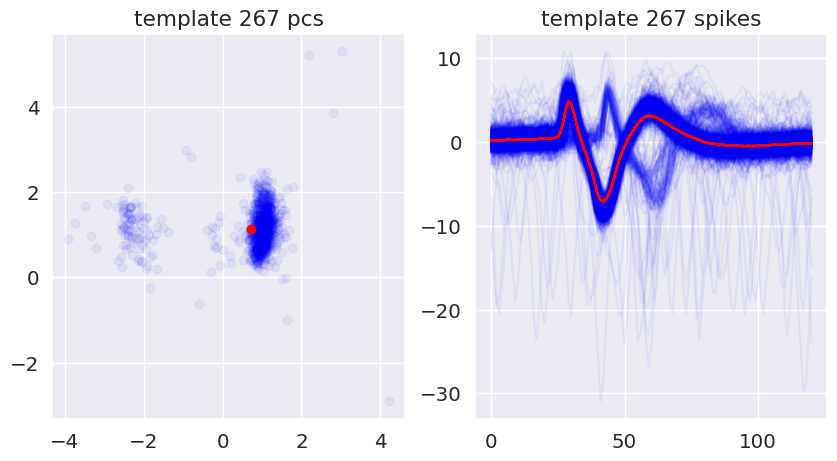

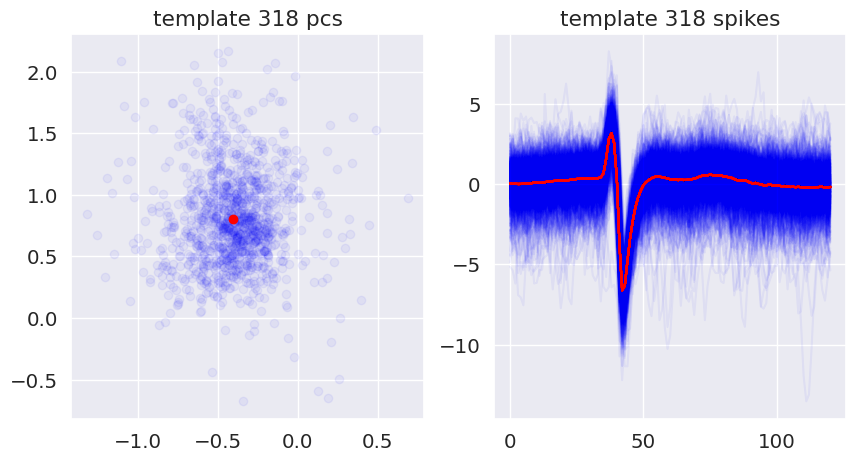

In [58]:
num_plot = 1200
units_plot = [0, 8]
for label_plot in units_plot:#range(len(np.unique(labels_train))):
    fig, axes = plt.subplots(1,2,figsize=(10,5))
    pcs = pcs_train[np.where(labels_train==label_plot)][:num_plot]
    axes[0].scatter(pcs[:,0], pcs[:,1], color='blue', alpha=.05)
    axes[0].scatter(np.mean(pcs,0)[0], np.mean(pcs,0)[1], color='red', alpha=1)
    spikes = wfs_train[np.where(labels_train==label_plot)]
    for spike in spikes[:num_plot]:
        axes[1].plot(spike.flatten(), color='blue', alpha=.05)
        axes[1].plot(np.mean(spikes, 0).flatten(), color='red')
    axes[0].set_title(f'template {label_plot} pcs')
    axes[1].set_title(f'template {label_plot} spikes')
    plt.show()

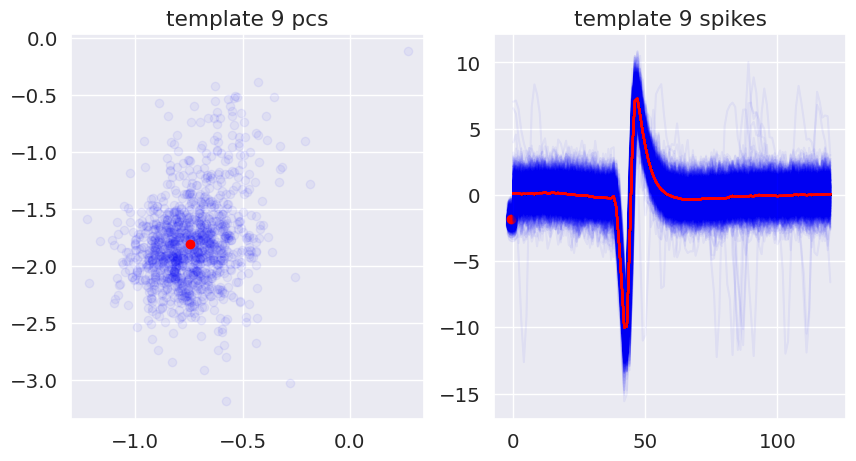

In [43]:
num_plot = 1200
units_plot = [0, 2]
for label_plot in units_plot:#range(len(np.unique(labels_train))):
    fig, axes = plt.subplots(1,2,figsize=(10,5))
    pcs = pcs_train[np.where(labels_train==label_plot)][:num_plot]
    axes[0].scatter(pcs[:,0], pcs[:,1], color='blue', alpha=.05)
    axes[0].scatter(np.mean(pcs,0)[0], np.mean(pcs,0)[1], color='red', alpha=1)
    axes[1].scatter(pcs[:,0], pcs[:,1], color='blue', alpha=.05)
    axes[1].scatter(np.mean(pcs,0)[0], np.mean(pcs,0)[1], color='red', alpha=1)
    spikes = wfs_train[np.where(labels_train==label_plot)]
    for spike in spikes[:num_plot]:
        axes[1].plot(spike.flatten(), color='blue', alpha=.05)
        axes[1].plot(np.mean(spikes, 0).flatten(), color='red')
    axes[0].set_title(f'template {selected_units[label_plot]} pcs')
    axes[1].set_title(f'template {selected_units[label_plot]} spikes')
    plt.show()

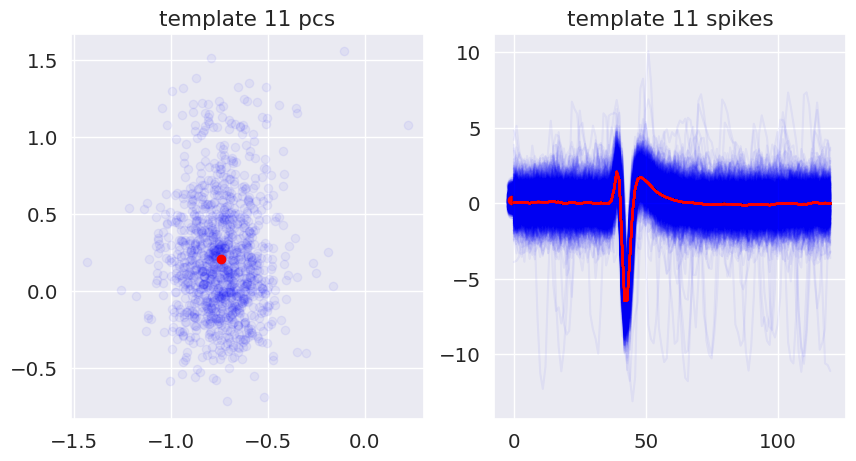

In [44]:
num_plot = 1200
units_plot = [1, 9]
for label_plot in units_plot:#range(len(np.unique(labels_train))):
    fig, axes = plt.subplots(1,2,figsize=(10,5))
    pcs = pcs_train[np.where(labels_train==label_plot)][:num_plot]
    axes[0].scatter(pcs[:,0], pcs[:,1], color='blue', alpha=.05)
    axes[0].scatter(np.mean(pcs,0)[0], np.mean(pcs,0)[1], color='red', alpha=1)
    axes[1].scatter(pcs[:,0], pcs[:,1], color='blue', alpha=.05)
    axes[1].scatter(np.mean(pcs,0)[0], np.mean(pcs,0)[1], color='red', alpha=1)
    spikes = wfs_train[np.where(labels_train==label_plot)]
    for spike in spikes[:num_plot]:
        axes[1].plot(spike.flatten(), color='blue', alpha=.05)
        axes[1].plot(np.mean(spikes, 0).flatten(), color='red')
    axes[0].set_title(f'template {selected_units[label_plot]} pcs')
    axes[1].set_title(f'template {selected_units[label_plot]} spikes')
    plt.show()

In [223]:
X_pca = learn_manifold_umap(denoised_pcs_test, umap_dim=2, umap_min_dist=0.2, umap_metric='euclidean', umap_neighbors=10)
clustering = MeanShift(bandwidth=2, n_jobs=20).fit(X_pca)
labels_test_ms_pcs = clustering.predict(X_pca)
score = adjusted_rand_score(labels_test, labels_test_ms_pcs)*100

number of seeds: 3000
seeds/job: 151
using 20 cpus


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   3 out of  20 | elapsed:   20.0s remaining:  1.9min
[Parallel(n_jobs=20)]: Done  14 out of  20 | elapsed:   24.7s remaining:   10.6s


predicting


[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:   27.1s finished


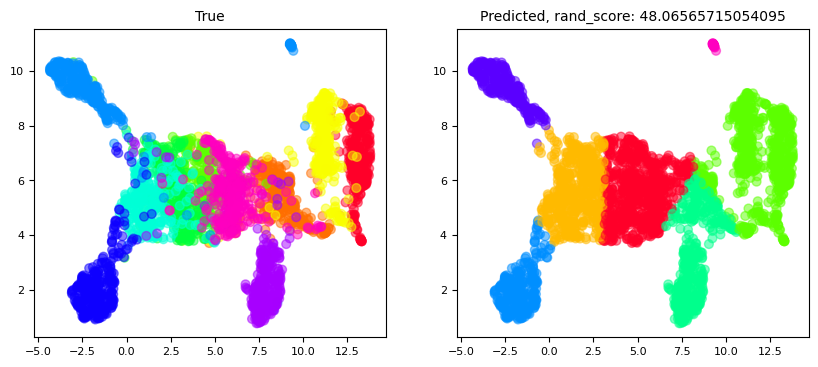

In [224]:
fig, axes = plt.subplots(1,2,figsize=(10,4))
# X = pcs_test
axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=labels_test, s=40, cmap='gist_rainbow', zorder=2, alpha=.5)
axes[1].scatter(X_pca[:, 0], X_pca[:, 1], c=labels_test_ms_pcs, s=40, cmap='gist_rainbow', zorder=2, alpha=.5)
axes[0].set_title('True')
axes[1].set_title(f'Predicted, rand_score: {score}');

In [71]:
reps_train = pcs_train
reps_test = pcs_test
for num_c in np.arange(2, denoised_pcs_train.shape[1]+1):
    gm = GaussianMixture(model_params['n_clusters'], 
                         random_state=0, 
                         covariance_type='full').fit(reps_train[:,:num_c])
    test_labels = gm.predict(reps_test[:,:num_c])
    score = adjusted_rand_score(labels_test, test_labels)*100
    print(f"num_comps: {num_c}, rand_score: {score}")

num_comps: 2, rand_score: 51.86089914696319
num_comps: 3, rand_score: 63.42369848143862
num_comps: 4, rand_score: 61.88944653728431
num_comps: 5, rand_score: 58.36880180978419
num_comps: 6, rand_score: 61.341115386493314
num_comps: 7, rand_score: 59.03326543900942
num_comps: 8, rand_score: 62.923237345998196
num_comps: 9, rand_score: 67.13956997337473
num_comps: 10, rand_score: 62.07962982569985
num_comps: 11, rand_score: 62.819179954212466
num_comps: 12, rand_score: 62.81706257288556
num_comps: 13, rand_score: 49.943828257211145
num_comps: 14, rand_score: 52.65677649300443
num_comps: 15, rand_score: 68.90455785792355
num_comps: 16, rand_score: 61.60542468764141
num_comps: 17, rand_score: 69.48138484846874
num_comps: 18, rand_score: 67.33510820397154
num_comps: 19, rand_score: 58.4900380008338
num_comps: 20, rand_score: 59.51118907547117


In [47]:
train_list = [pcs_train[:,:2], denoised_pcs_train[:,:2], pcs_train[:,:5], denoised_pcs_train[:,:5]]
test_list = [pcs_test[:,:2], denoised_pcs_test[:,:2], pcs_test[:,:5], denoised_pcs_test[:,:5]]

cluster_method = 'GMM'
models = [f'{cluster_method} Single-chan, num pcs: {train_list[0].shape[1]}', 
          f'{cluster_method} Denoised single-chan, num pcs: {train_list[1].shape[1]}',
          f'{cluster_method} Single-chan, num pcs: {train_list[2].shape[1]}',
          f'{cluster_method} Denoised single-chan, num pcs: {train_list[3].shape[1]}'] 

num_classes = len(np.unique(labels_test))
model_params = {'n_clusters':15, 'min_cluster_size':20}
per_class_map = per_class_accs(train_list, test_list, models, num_classes, cluster_method.lower(), unit_ids, model_params)
avg_class_map = avg_class_accs(train_list, test_list, models, num_classes, cluster_method.lower(), model_params)

pc_df = pd.DataFrame.from_dict(per_class_map, 'index')
ac_df = pd.DataFrame.from_dict(avg_class_map)

with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(pc_df)
    
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(ac_df)

wf 8  wf 9  wf 11  wf 13  wf 23  wf 24   
GMM Single-chan, num pcs: 2            0.0   0.0    0.0    0.0    0.0    0.0  \
GMM Denoised single-chan, num pcs: 2   0.0   0.0    0.0    0.0    0.0    0.0   
GMM Single-chan, num pcs: 5            0.0   0.0    0.0    0.0    0.0    0.0   
GMM Denoised single-chan, num pcs: 5   0.0   0.0    0.0    0.0    0.0    0.0   

                                      wf 29  wf 30  wf 31  wf 32  
GMM Single-chan, num pcs: 2             0.0    0.0    0.0    0.0  
GMM Denoised single-chan, num pcs: 2    0.0    0.0    0.0    0.0  
GMM Single-chan, num pcs: 5             0.0    0.0    0.0    0.0  
GMM Denoised single-chan, num pcs: 5    0.0    0.0    0.0    0.0

GMM Single-chan, num pcs: 2  GMM Denoised single-chan, num pcs: 2   
score                    51.860899                             40.873502  \

       GMM Single-chan, num pcs: 5  GMM Denoised single-chan, num pcs: 5  
score                    60.785662                             48.298136

In [ ]:
mearec_denoised_wfs_train_locs.std(0).mean()

In [ ]:
mearec_exp_var = pca(np.array([mc.flatten() for mc in mearec_wfs_train]), 4)[1]
print(mearec_exp_var)
print(np.sum(mearec_exp_var))

Using projector; batchnorm False with depth 2
train done
pca test done
300
(3000,)
Using projector; batchnorm False with depth 2
train done
pca test done
300
(3000,)
Using projector; batchnorm False with depth 2
train done
pca test done
300
(3000,)
Using projector; batchnorm False with depth 2
train done
pca test done
300
(3000,)
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.


wf 8       wf 9      wf 11  \
PCA 2D                                            100.0  99.333333  62.666667   
PCA 3D                                            100.0  98.666667  61.000000   
PCA 5D                                            100.0  98.666667  76.333333   
PCA 10D                                           100.0  96.000000  75.333333   
Contrastive 2D (augs=amp/jit/noise, fc encoder)   100.0  97.333333  84.666667   
Contrastive 3D (augs=amp/jit/noise, fc encoder)   100.0  96.333333  94.000000   
Contrastive 5D (augs=amp/jit/noise, fc encoder)   100.0  98.000000  90.666667   
Contrastive 10D (augs=amp/jit/noise, fc encoder)  100.0  98.000000  92.333333   

                                                      wf 33      wf 65  \
PCA 2D                                            82.333333  75.333333   
PCA 3D                                            92.333333  82.000000   
PCA 5D                                            92.000000  86.333333   
PCA 10D                                           93.000000  89.333333   
Contrastive 2D (augs=amp/jit/noise, fc encoder)   91.666667  88.666667   
Contrastive 3D (augs=amp/jit/noise, fc encoder)   95.333333  87.666667   
Contrastive 5D (augs=amp/jit/noise, fc encoder)   93.666667  86.000000   
Contrastive 10D (augs=amp/jit/noise, fc encoder)  94.000000  90.666667   

                                                      wf 69     wf 109  \
PCA 2D                                            49.000000  62.000000   
PCA 3D                                            46.666667  60.333333   
PCA 5D                                            43.000000  55.000000   
PCA 10D                                           53.000000  37.333333   
Contrastive 2D (augs=amp/jit/noise, fc encoder)   51.333333  19.666667   
Contrastive 3D (augs=amp/jit/noise, fc encoder)   44.666667  39.000000   
Contrastive 5D (augs=amp/jit/noise, fc encoder)   48.000000  38.666667   
Contrastive 10D (augs=amp/jit/noise, fc encoder)  47.333333  33.000000   

                                                      wf 13     wf 329  \
PCA 2D                                            88.666667  17.666667   
PCA 3D                                            93.000000  24.333333   
PCA 5D                                            92.000000  49.333333   
PCA 10D                                           97.000000  70.000000   
Contrastive 2D (augs=amp/jit/noise, fc encoder)   95.666667  64.666667   
Contrastive 3D (augs=amp/jit/noise, fc encoder)   96.000000  57.000000   
Contrastive 5D (augs=amp/jit/noise, fc encoder)   93.666667  64.666667   
Contrastive 10D (augs=amp/jit/noise, fc encoder)  94.666667  74.333333   

                                                     wf 151  
PCA 2D                                            63.000000  
PCA 3D                                            67.333333  
PCA 5D                                            79.000000  
PCA 10D                                           88.333333  
Contrastive 2D (augs=amp/jit/noise, fc encoder)   92.333333  
Contrastive 3D (augs=amp/jit/noise, fc encoder)   89.666667  
Contrastive 5D (augs=amp/jit/noise, fc encoder)   94.666667  
Contrastive 10D (augs=amp/jit/noise, fc encoder)  93.333333

PCA 2D     PCA 3D     PCA 5D    PCA 10D  \
score  69.966667  73.066667  76.933333  81.233333   

       Contrastive 2D (augs=amp/jit/noise, fc encoder)  \
score                                        78.433333   

       Contrastive 3D (augs=amp/jit/noise, fc encoder)  \
score                                             79.9   

       Contrastive 5D (augs=amp/jit/noise, fc encoder)  \
score                                        80.966667   

       Contrastive 10D (augs=amp/jit/noise, fc encoder)  
score                                         81.566667

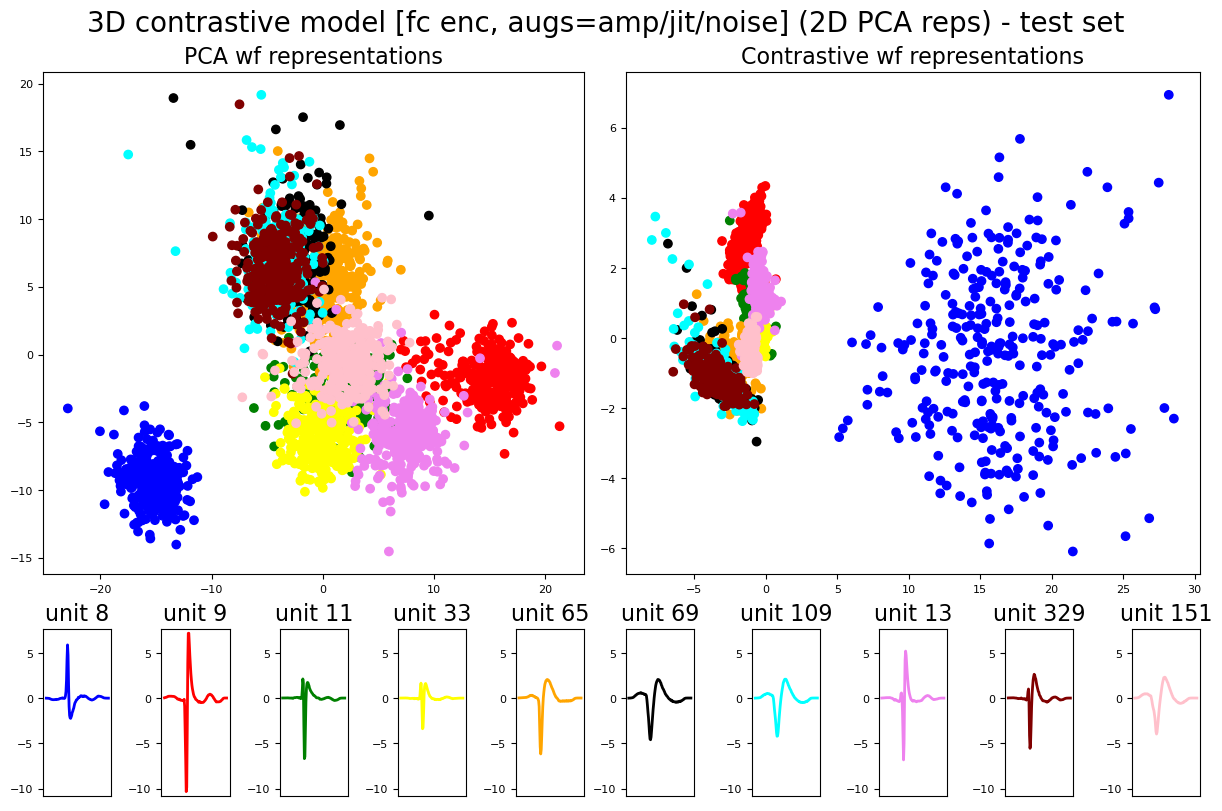

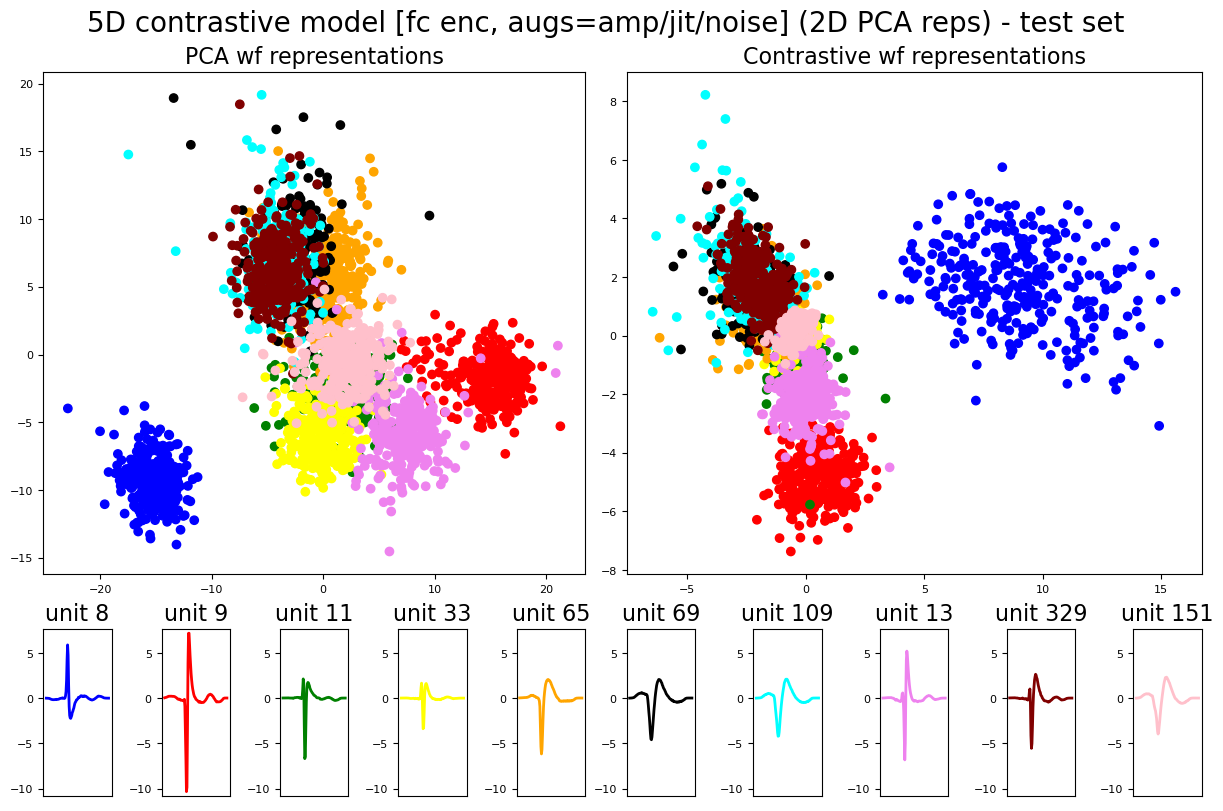

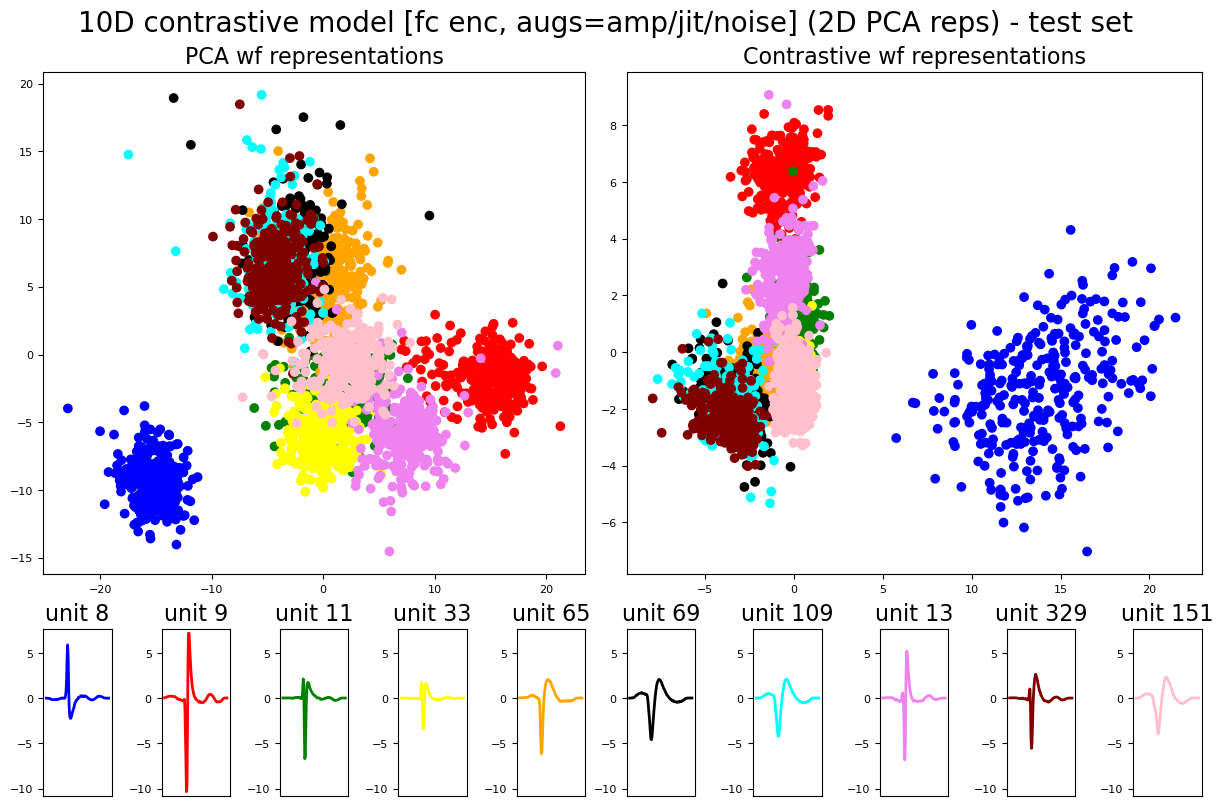

In [185]:
twod_norm_fcenc_path = '/Users/ankit/Documents/PaninskiLab/SimCLR-torch/runs/new_augs/fcenc-2d2d-normal-lr001/checkpoint_0400.pth.tar'
threed_norm_fcenc_path = '/Users/ankit/Documents/PaninskiLab/SimCLR-torch/runs/new_augs/fcenc-3d3d-normal-lr001/checkpoint_0400.pth.tar'
fived_norm_fcenc_path = '/Users/ankit/Documents/PaninskiLab/SimCLR-torch/runs/new_augs/fcenc-5d5d-normal/checkpoint_0500.pth.tar'
tend_norm_fcenc_path = '/Users/ankit/Documents/PaninskiLab/SimCLR-torch/runs/new_augs/fcenc-10d5d-normal-lr001/checkpoint_0400.pth.tar'


contr_reps_train_2d_n, contr_reps_test_2d_n, contr_reps_test_2d_pca_n, pca_train_2d, pca_test_2d = get_ckpt_results(twod_norm_fcenc_path, 2, dy_wfs_interest, dy_wfs_test, True, dy_wfs, wf_interest_dy, '2D contrastive model [fc enc, augs=amp/jit/noise] (2D PCA reps) - test set', enc_type='fc_encoder', Lv=[121, 550, 1100, 250], save_name='pca_v_2dcont_normal_fcenc')
contr_reps_train_3d_n, contr_reps_test_3d_n, contr_reps_test_3d_pca_n, pca_train_3d, pca_test_3d = get_ckpt_results(threed_norm_fcenc_path, 3, dy_wfs_interest, dy_wfs_test, True, dy_wfs, wf_interest_dy, '3D contrastive model [fc enc, augs=amp/jit/noise] (2D PCA reps) - test set', enc_type='fc_encoder', Lv=[121, 550, 1100, 250], save_name='pca_v_3dcont_normal_fcenc')
contr_reps_train_5d_n, contr_reps_test_5d_n, contr_reps_test_5d_pca_n, pca_train_5d, pca_test_5d = get_ckpt_results(fived_norm_fcenc_path, 5, dy_wfs_interest, dy_wfs_test, True, dy_wfs, wf_interest_dy, '5D contrastive model [fc enc, augs=amp/jit/noise] (2D PCA reps) - test set', enc_type='fc_encoder', Lv=[121, 550, 1100, 250], save_name='pca_v_5dcont_normal_fcenc')
contr_reps_train_10d_n, contr_reps_test_10d_n, contr_reps_test_10d_pca_n, pca_train_10d, pca_test_10d = get_ckpt_results(tend_norm_fcenc_path, 10, dy_wfs_interest, dy_wfs_test, True, dy_wfs, wf_interest_dy, '10D contrastive model [fc enc, augs=amp/jit/noise] (2D PCA reps) - test set', enc_type='fc_encoder', Lv=[121, 550, 1100, 250], save_name='pca_v_10dcont_normal_fcenc')


train_reps = [pca_train_2d, pca_train_3d, pca_train_5d, pca_train_10d, 
              contr_reps_train_2d_n, contr_reps_train_3d_n, contr_reps_train_5d_n, 
              contr_reps_train_10d_n]
test_reps = [pca_test_2d, pca_test_3d, pca_test_5d, pca_test_10d,
             contr_reps_test_2d_n, contr_reps_test_3d_n, contr_reps_test_5d_n, 
             contr_reps_test_10d_n]
models = ['PCA 2D', 'PCA 3D', 'PCA 5D', 'PCA 10D',
          'Contrastive 2D (augs=amp/jit/noise, fc encoder)', 'Contrastive 3D (augs=amp/jit/noise, fc encoder)',
          'Contrastive 5D (augs=amp/jit/noise, fc encoder)', 'Contrastive 10D (augs=amp/jit/noise, fc encoder)']


per_class_map = per_class_accs(train_reps, test_reps, models, 10)
avg_class_map = avg_class_accs(train_reps, test_reps, models, 10)

pc_df = pd.DataFrame.from_dict(per_class_map, 'index')
ac_df = pd.DataFrame.from_dict(avg_class_map)

with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(pc_df)
    
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(ac_df)

In [58]:
train_reps = [pca_train_2d, pca_train_5d, pca_train_10d, pca_train_20d, contr_reps_train_2d, contr_reps_train_5d, contr_reps_train_10d, contr_reps_train_20d]
test_reps = [pca_test_2d, pca_test_5d, pca_test_10d, pca_test_20d, contr_reps_2d, contr_reps_5d, contr_reps_10d, contr_reps_20d]
models = ['PCA 2D', 'PCA 5D', 'PCA 10D', 'PCA 20D', 'Contrastive 2D (lr=0.001)', 'Contrastive 5D (lr=0.001)', 'Contrastive 10D (lr=0.001)', 'Contrastive 20D (lr=0.001)']

per_class_map = per_class_accs(train_reps, test_reps, models, 10)
avg_class_map = avg_class_accs(train_reps, test_reps, models, 10)

Starting epoch 1
Starting epoch 2
Starting epoch 3
Starting epoch 4
Starting epoch 5
Starting epoch 6
Starting epoch 7
Starting epoch 8
Starting epoch 9
Starting epoch 10
Starting epoch 11
Starting epoch 12
Starting epoch 13
Starting epoch 14
Starting epoch 15
Starting epoch 16
Starting epoch 17
Starting epoch 18
Starting epoch 19
Starting epoch 20
Starting epoch 21
Starting epoch 22
Starting epoch 23
Starting epoch 24
Starting epoch 25
Starting epoch 26
Starting epoch 27
Starting epoch 28
Starting epoch 29
Starting epoch 30
Starting epoch 31
Starting epoch 32
Starting epoch 33
Starting epoch 34
Starting epoch 35
Starting epoch 36
Starting epoch 37
Starting epoch 38
Starting epoch 39
Starting epoch 40
Starting epoch 41
Starting epoch 42
Starting epoch 43
Starting epoch 44
Starting epoch 45
Starting epoch 46
Starting epoch 47
Starting epoch 48
Starting epoch 49
Starting epoch 50
Starting epoch 51
Starting epoch 52
Starting epoch 53
Starting epoch 54
Starting epoch 55
Starting epoch 56
S

In [59]:
pc_df = pd.DataFrame.from_dict(per_class_map, 'index')
ac_df = pd.DataFrame.from_dict(avg_class_map)

In [60]:
# pd.set_option('display.max_rows', 10)
# display(pc_df)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(pc_df)

wf 8       wf 9      wf 11      wf 33  \
PCA 2D                      100.000000  98.666667  48.666667  84.333333   
PCA 5D                      100.000000  99.333333  75.000000  92.666667   
PCA 10D                      99.666667  98.666667  82.666667  93.333333   
PCA 20D                     100.000000  95.000000  84.666667  93.000000   
Contrastive 2D (lr=0.001)    97.333333  86.000000  74.666667  62.333333   
Contrastive 5D (lr=0.001)   100.000000  95.666667  90.666667  86.666667   
Contrastive 10D (lr=0.001)  100.000000  94.333333  86.666667  79.666667   
Contrastive 20D (lr=0.001)  100.000000  92.666667  87.000000  82.666667   

                                wf 65      wf 69     wf 109      wf 13  \
PCA 2D                      75.000000  61.000000   0.000000  91.666667   
PCA 5D                      85.333333  42.000000  53.333333  91.000000   
PCA 10D                     90.666667  55.000000  50.666667  94.000000   
PCA 20D                     92.000000  51.333333  46.333333  94.333333   
Contrastive 2D (lr=0.001)   85.333333  43.666667  26.666667  74.666667   
Contrastive 5D (lr=0.001)   88.000000  59.333333  26.333333  78.666667   
Contrastive 10D (lr=0.001)  86.000000  60.000000  25.333333  79.000000   
Contrastive 20D (lr=0.001)  85.666667  44.000000  40.000000  86.000000   

                               wf 329     wf 151  
PCA 2D                      66.000000  70.333333  
PCA 5D                      50.333333  80.000000  
PCA 10D                     57.666667  85.000000  
PCA 20D                     69.000000  86.000000  
Contrastive 2D (lr=0.001)   49.000000  77.666667  
Contrastive 5D (lr=0.001)   69.333333  90.666667  
Contrastive 10D (lr=0.001)  62.666667  87.333333  
Contrastive 20D (lr=0.001)  62.333333  83.333333

In [61]:
# pd.set_option('display.max_rows', 10)
# display(pc_df)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(ac_df)

PCA 2D     PCA 5D    PCA 10D  PCA 20D  Contrastive 2D (lr=0.001)  \
score  69.766667  76.966667  80.566667     81.0                       67.7   

       Contrastive 5D (lr=0.001)  Contrastive 10D (lr=0.001)  \
score                  77.933333                   76.033333   

       Contrastive 20D (lr=0.001)  
score                   76.866667

Using projector; batchnorm False with depth 2
train done
pca test done
300
(3000,)
Using projector; batchnorm False with depth 2
train done
pca test done
300
(3000,)
Using projector; batchnorm False with depth 2
train done
pca test done
300
(3000,)
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.


wf 8       wf 9      wf 11      wf 33  \
PCA 10D                     100.000000  97.333333  78.666667  93.000000   
PCA 20D                      99.666667  96.333333  85.333333  92.000000   
Contrastive 10D (lr=0.001)  100.000000  93.000000  89.666667  83.333333   
Contrastive 10D (lr=0.005)  100.000000  92.000000  86.666667  82.333333   
Contrastive 20D (lr=0.001)   99.666667  94.333333  90.333333  87.000000   

                                wf 65      wf 69     wf 109      wf 13  \
PCA 10D                     86.333333  58.000000  32.666667  94.666667   
PCA 20D                     90.333333  52.666667  58.666667  92.333333   
Contrastive 10D (lr=0.001)  89.333333  51.666667  29.000000  85.333333   
Contrastive 10D (lr=0.005)  78.666667  54.333333  23.000000  84.000000   
Contrastive 20D (lr=0.001)  85.666667  53.333333  41.666667  89.333333   

                               wf 329     wf 151  
PCA 10D                     69.333333  87.666667  
PCA 20D                     58.000000  83.333333  
Contrastive 10D (lr=0.001)  65.333333  88.000000  
Contrastive 10D (lr=0.005)  65.333333  82.333333  
Contrastive 20D (lr=0.001)  58.000000  86.333333

PCA 10D    PCA 20D  Contrastive 10D (lr=0.001)  \
score     80.7  80.766667                        77.1   

       Contrastive 10D (lr=0.005)  Contrastive 20D (lr=0.001)  
score                   74.433333                        78.4

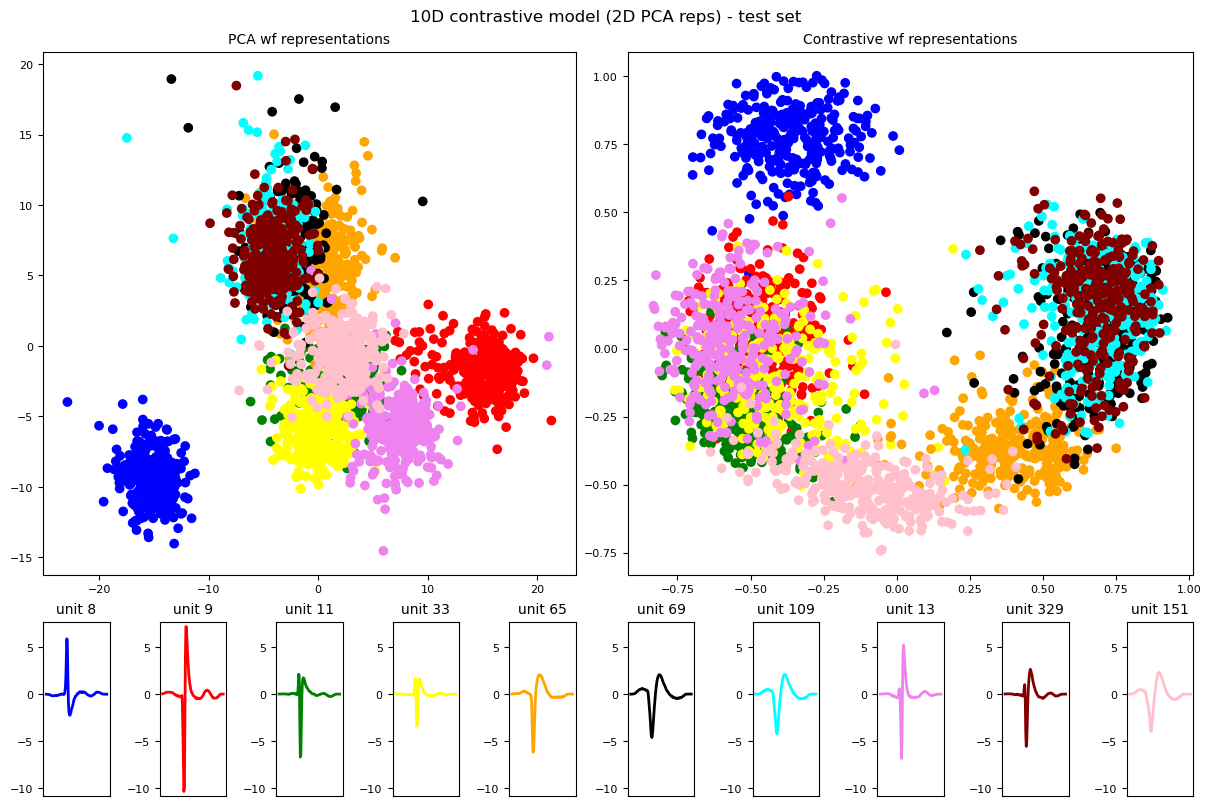

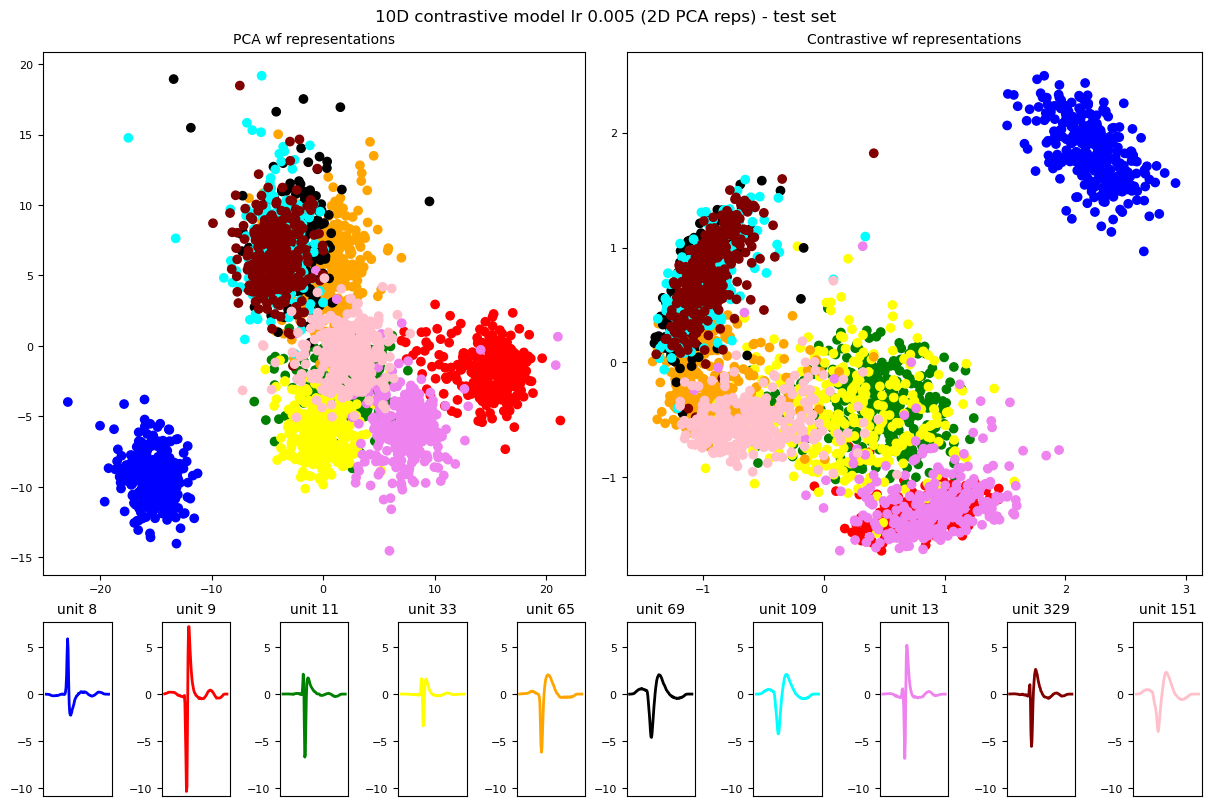

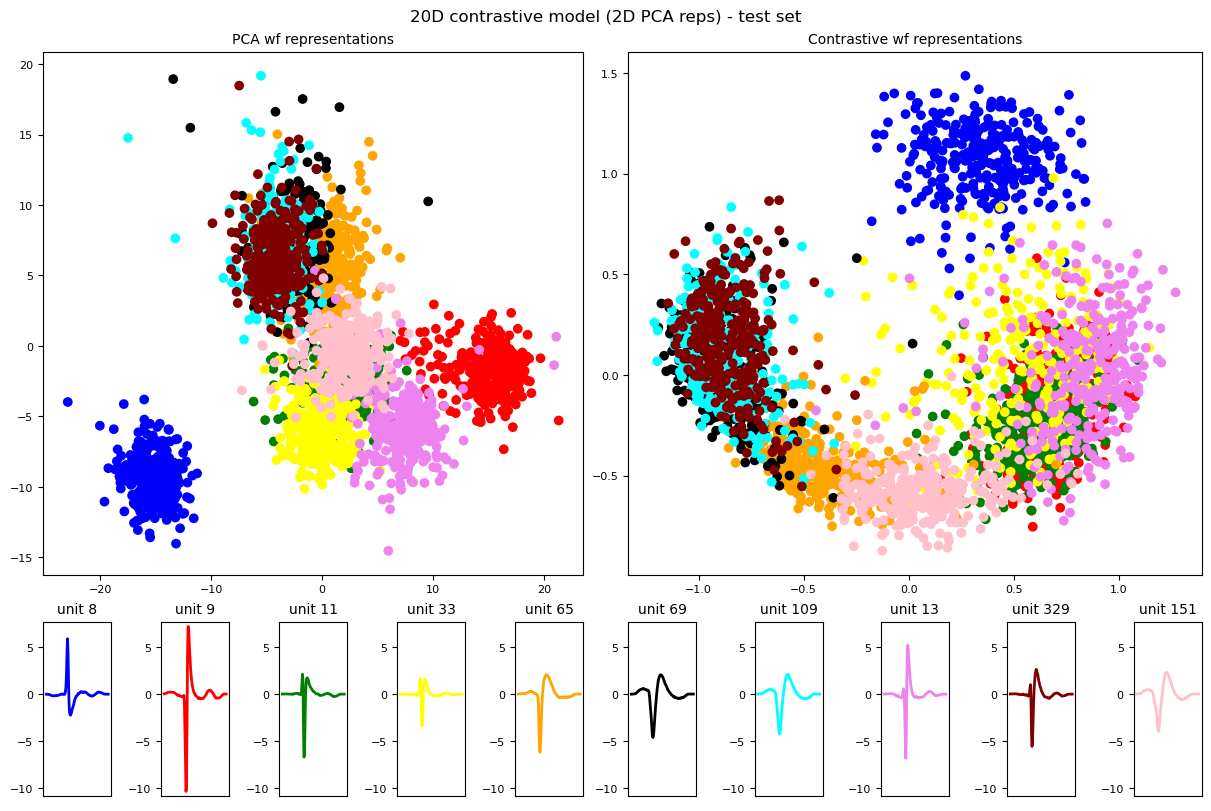

In [98]:
tend_enc_path = '/Users/ankit/Documents/PaninskiLab/SimCLR-torch/runs/proj_dim_5/enc-10d-pd-lr001/checkpoint_1000.pth.tar'
twentyd_enc_path = '/Users/ankit/Documents/PaninskiLab/SimCLR-torch/runs/proj_dim_5/enc-20d-pd-lr001/checkpoint_1000.pth.tar'
tend_lr_enc_path = '/Users/ankit/Documents/PaninskiLab/SimCLR-torch/runs/proj_dim_5/enc-10d-pd-lr005/checkpoint_1000.pth.tar'

contr_reps_train_10d, contr_reps_test_10d, contr_reps_test_10d_pca, pca_train_10d, pca_test_10d = get_ckpt_results(tend_enc_path, 10, dy_wfs_interest, dy_wfs_test, True, dy_wfs, wf_interest_dy, '10D contrastive model (2D PCA reps) - test set', save_name='pca_v_10dcont_pjlr001_sdv4')
contr_reps_train_10d_lr, contr_reps_test_10d_lr, contr_reps_test_10d_lr_pca, _, _ = get_ckpt_results(tend_lr_enc_path, 10, dy_wfs_interest, dy_wfs_test, True, dy_wfs, wf_interest_dy, '10D contrastive model lr 0.005 (2D PCA reps) - test set', save_name='pca_v_10dcont_pjlr005_sdv4')
contr_reps_train_20d, contr_reps_test_20d, contr_reps_test_20d_pca, pca_train_20d, pca_test_20d = get_ckpt_results(twentyd_enc_path, 20, dy_wfs_interest, dy_wfs_test, True, dy_wfs, wf_interest_dy, '20D contrastive model (2D PCA reps) - test set', save_name='pca_v_20dcont_pjlr001_sdv4')

train_reps = [pca_train_10d, pca_train_20d, contr_reps_train_10d, contr_reps_train_10d_lr, contr_reps_train_20d]
test_reps = [pca_test_10d, pca_test_20d, contr_reps_test_10d, contr_reps_test_10d_lr, contr_reps_test_20d]
models = ['PCA 10D', 'PCA 20D', 'Contrastive 10D (lr=0.001)', 'Contrastive 10D (lr=0.005)', 'Contrastive 20D (lr=0.001)']

per_class_map = per_class_accs(train_reps, test_reps, models, 10)
avg_class_map = avg_class_accs(train_reps, test_reps, models, 10)

pc_df = pd.DataFrame.from_dict(per_class_map, 'index')
ac_df = pd.DataFrame.from_dict(avg_class_map)

with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(pc_df)
    
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(ac_df)

Using projector; batchnorm False with depth 2
train done
pca test done
300
(3000,)
Using projector; batchnorm False with depth 2
train done
pca test done
300
(3000,)
Using projector; batchnorm False with depth 2
train done
pca test done
300
(3000,)
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.


wf 8       wf 9  \
PCA 10D                                         100.000000  99.000000   
PCA 20D                                         100.000000  96.333333   
Contrastive 10D (lr=0.001)                      100.000000  92.666667   
Contrastive 10D (lr=0.001, noise/collision on)  100.000000  96.666667   
Contrastive 20D (lr=0.001)                       99.666667  95.666667   

                                                    wf 11      wf 33  \
PCA 10D                                         80.333333  92.333333   
PCA 20D                                         82.000000  92.333333   
Contrastive 10D (lr=0.001)                      89.000000  84.000000   
Contrastive 10D (lr=0.001, noise/collision on)  89.666667  81.333333   
Contrastive 20D (lr=0.001)                      90.333333  84.000000   

                                                    wf 65      wf 69  \
PCA 10D                                         87.333333  53.000000   
PCA 20D                                         87.666667  39.333333   
Contrastive 10D (lr=0.001)                      89.333333  57.000000   
Contrastive 10D (lr=0.001, noise/collision on)  83.333333  27.000000   
Contrastive 20D (lr=0.001)                      85.333333  51.333333   

                                                   wf 109      wf 13  \
PCA 10D                                         52.000000  94.666667   
PCA 20D                                         51.666667  93.000000   
Contrastive 10D (lr=0.001)                      30.666667  85.000000   
Contrastive 10D (lr=0.001, noise/collision on)  48.000000  89.333333   
Contrastive 20D (lr=0.001)                      37.666667  88.000000   

                                                   wf 329     wf 151  
PCA 10D                                         62.000000  87.333333  
PCA 20D                                         54.666667  85.666667  
Contrastive 10D (lr=0.001)                      57.333333  87.666667  
Contrastive 10D (lr=0.001, noise/collision on)  69.333333  88.333333  
Contrastive 20D (lr=0.001)                      65.333333  90.666667

PCA 10D    PCA 20D  Contrastive 10D (lr=0.001)  \
score  80.133333  77.733333                   77.366667   

       Contrastive 10D (lr=0.001, noise/collision on)  \
score                                       77.133333   

       Contrastive 20D (lr=0.001)  
score                   78.766667

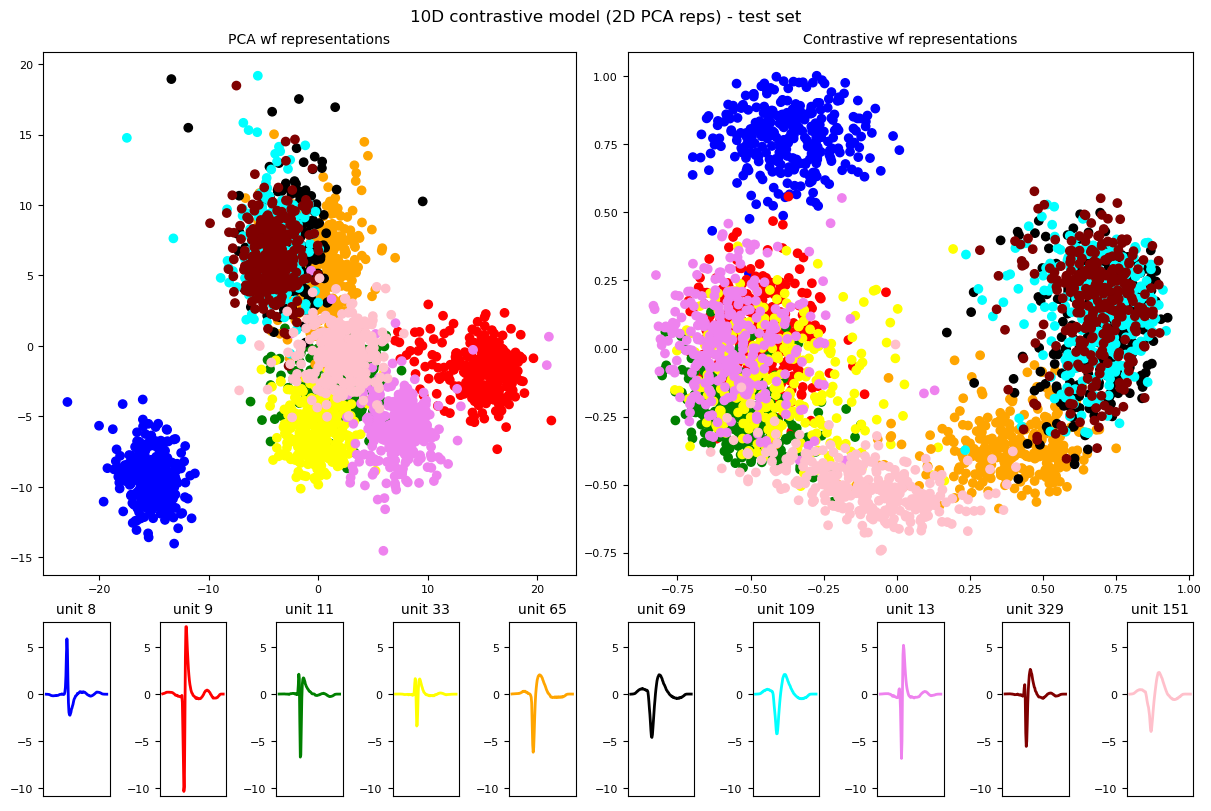

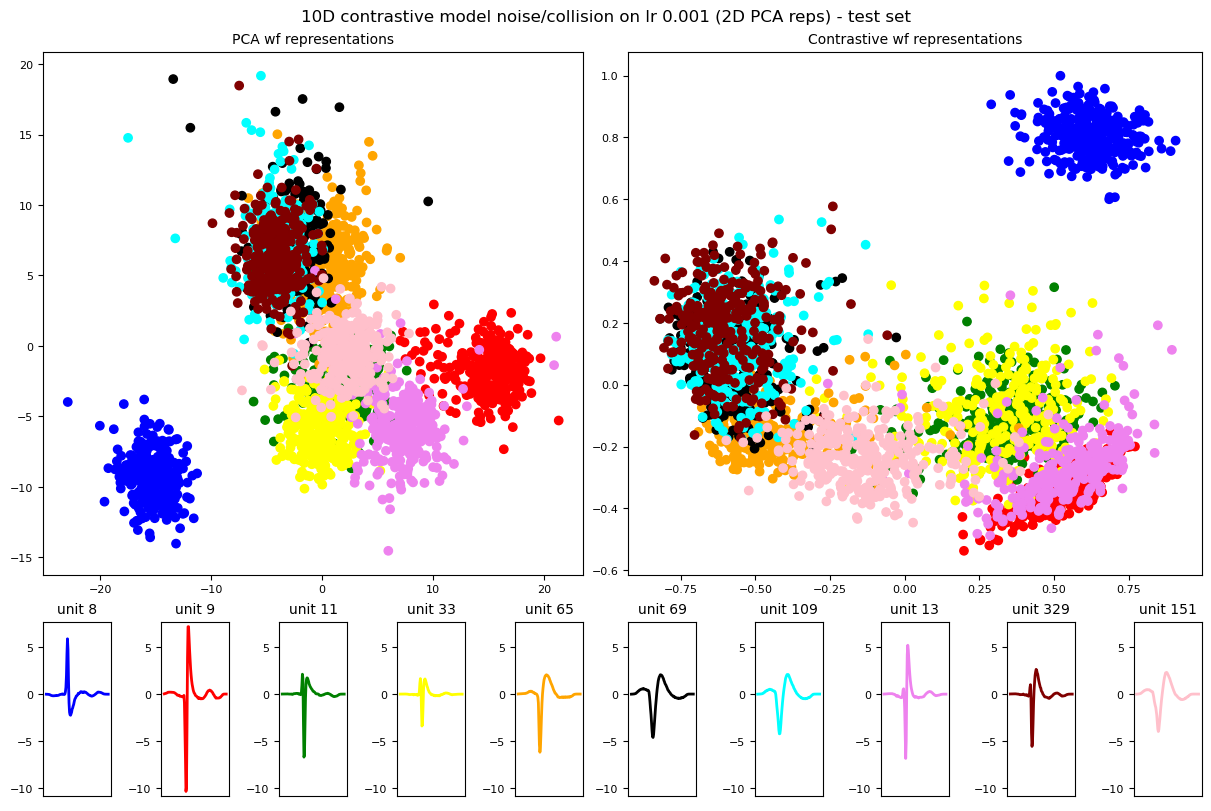

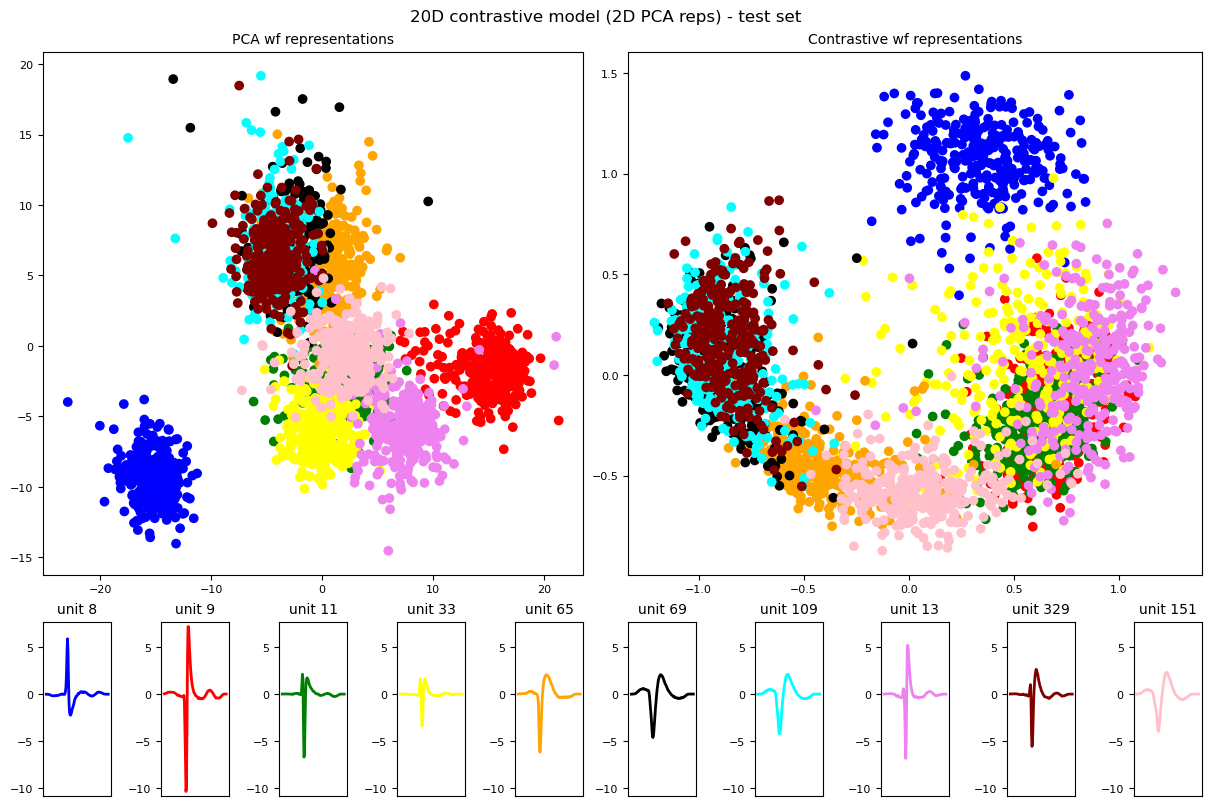

In [51]:
tend_enc_path = '/Users/ankit/Documents/PaninskiLab/SimCLR-torch/runs/proj_dim_5/enc-10d-pd-lr001/checkpoint_1000.pth.tar'
twentyd_enc_path = '/Users/ankit/Documents/PaninskiLab/SimCLR-torch/runs/proj_dim_5/enc-20d-pd-lr001/checkpoint_1000.pth.tar'
tend_na_enc_path = '/Users/ankit/Documents/PaninskiLab/SimCLR-torch/runs/new_augs/enc-10d-lr001/checkpoint_1000.pth.tar'

contr_reps_train_10d, contr_reps_test_10d, contr_reps_test_10d_pca, pca_train_10d, pca_test_10d = get_ckpt_results(tend_enc_path, 10, dy_wfs_interest, dy_wfs_test, True, dy_wfs, wf_interest_dy, '10D contrastive model (2D PCA reps) - test set', save_name='pca_v_10dcont_pjlr001_sdv4')
contr_reps_train_10d_na, contr_reps_test_10d_na, contr_reps_test_10d_na_pca, _, _ = get_ckpt_results(tend_na_enc_path, 10, dy_wfs_interest, dy_wfs_test, True, dy_wfs, wf_interest_dy, '10D contrastive model noise/collision on lr 0.001 (2D PCA reps) - test set', save_name='pca_v_10dcont_pjlr005_ua_sdv4')
contr_reps_train_20d, contr_reps_test_20d, contr_reps_test_20d_pca, pca_train_20d, pca_test_20d = get_ckpt_results(twentyd_enc_path, 20, dy_wfs_interest, dy_wfs_test, True, dy_wfs, wf_interest_dy, '20D contrastive model (2D PCA reps) - test set', save_name='pca_v_20dcont_pjlr001_sdv4')

train_reps = [pca_train_10d, pca_train_20d, contr_reps_train_10d, contr_reps_train_10d_na, contr_reps_train_20d]
test_reps = [pca_test_10d, pca_test_20d, contr_reps_test_10d, contr_reps_test_10d_na, contr_reps_test_20d]
models = ['PCA 10D', 'PCA 20D', 'Contrastive 10D (lr=0.001)', 'Contrastive 10D (lr=0.001, noise/collision on)', 'Contrastive 20D (lr=0.001)']

per_class_map = per_class_accs(train_reps, test_reps, models, 10)
avg_class_map = avg_class_accs(train_reps, test_reps, models, 10)

pc_df = pd.DataFrame.from_dict(per_class_map, 'index')
ac_df = pd.DataFrame.from_dict(avg_class_map)

with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(pc_df)
    
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(ac_df)